In [1]:
import h5py
import numpy as np
import math
import glob
import os
import umap
import hdbscan
import seaborn as sns
import pandas as pd
import pickle
import openpyxl
import cv2
from scipy import ndimage as ndi

from functools import reduce
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from moviepy.editor import *
import imageio


# General Functions

In [2]:
def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

def make_dict(my_list):
    my_dict = {}
    for i in range(len(my_list)):
        my_dict[my_list[i]] = i
    return my_dict

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

def smooth_diff(node_loc, deriv, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_vel = np.zeros_like(node_loc)
    for c in range(node_loc.shape[-1]):
        node_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv)
    if deriv != 0:
        node_vel = np.linalg.norm(node_vel,axis=1)
    return node_vel

class sleap_vid():

    def __init__(self, filename, track_no):
        self.name = filename
        self.features = {}
        self.mice = track_no
        self.get_info(filename)

    def get_info(self, filename):
        with h5py.File(filename, "r") as f:
            tracks= [n.decode() for n in f["track_names"][:]]
            locations = f["tracks"][:].T
            locations = locations[:,:,:,:self.mice]
            self.locations = fill_missing(locations)
            nodes = [n.decode() for n in f["node_names"][:]]
            self.tracks = tracks
            self.nodes = nodes
            self.track_dict = make_dict(tracks)
            self.node_dict = make_dict(nodes)

    def smooth_locations(self, win=25, poly=3):
        for node in self.node_dict.values():
            for track in range(self.mice):
                nodeloc = self.locations[:,node,:,track]
                smoothed_node = smooth_diff(nodeloc, deriv=0, win=win, poly=poly)
                self.locations[:,node,:,track] = smoothed_node
        

    def node_velocity(self, node, win=25, poly=3, normalization_factor=None):
        """
        takes in node and returns the velocity of that node 
        for each mouse

        Args: 
            node: string, name of node
        
        Returns:
            velocities: 2d np.array of floats (d = 2 x #of frames)
                where each element is the velocity for that node
                distances[0] = velocities for mouse2
                distances[1] = velocities for mouse2
        """
        node_loc1 = self.locations[:, self.node_dict[node], :, 0]
        node_loc2 = self.locations[:, self.node_dict[node], :, 1]
        if normalization_factor != None:
            node_loc1 = node_loc1 * normalization_factor
            node_loc2 = node_loc2 * normalization_factor
        m1_vel = smooth_diff(node_loc1, deriv = 1, win=win, poly=poly)
        m2_vel = smooth_diff(node_loc2, deriv = 1, win=win, poly=poly)
        velocities = np.array([m1_vel,m2_vel])
        return velocities 
   
    def distances_between_mice(self, node, normalization_factor=None):
        """
        takes in node name
        returns a list of distances between the nodes of the two mice

        Args:
            node: string, name of node
        Returns:
            c_list: 1D np.array of floats (d = # of frames)
        """
        locations = self.locations 
        node_index = self.node_dict[node]
        x1 = locations[:,node_index,0,0]
        y1 = locations[:,node_index,1,0]
        # x , y coordinate of nose for mouse 1
        x2 = locations[:,node_index,0,1]
        y2 =  locations[:,node_index,1,1]
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        distances = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None: 
            distances = distances * normalization_factor
            distances = distances.T.flatten()
        return distances
    
    def distances_between_nodes(self, node1, node2, normalization_factor = None):
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            node2: string, name of node 2 
        
        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node1 and node2 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index1 = self.node_dict[node1]
        node_index2 = self.node_dict[node2]
        x1,y1 = locations[:, node_index1,0,0], locations[:,node_index1,1,0]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[:,node_index2,0,0], locations[:,node_index2,1,0]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index1,0,1], locations[:,node_index1,1,1]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[:,node_index2,0,1], locations[:,node_index2,1,1]
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -x4)**2)+ ((y3 - y4)**2))
        c1 = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array[c1, c2]
        return distances
    
    def distances_to_point(self, node, point, normalization_factor = None):
        # CONFIRMED THAT IT WORKS in terms of doing the math by hand
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node and point 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index = self.node_dict[node]
        px, py = point[0], point[1]
        x1,y1 = locations[:, node_index,0,0], locations[:,node_index,1,0]
        # x , y coordinate of node 1 for mouse 1
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index,0,1], locations[:,node_index,1,1]
        # x and y coordinate of node 1 of mouse 2
        px = np.full_like(x1, fill_value=px)
        py = np.full_like(y1, fill_value=py)
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -px)**2)+ ((y3 - py)**2))
        c1 = np.sqrt(((x1 - px)**2) + ((y1 - py)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array([c1, c2])
        return distances


    def node_angles(self, node1, node2, node3):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            node3: string, name of node 3

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and node3 with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        node_index_3 = self.node_dict[node3]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        cx = locations[:,node_index_3,0,:]
        cy = locations[:,node_index_3, 1, :]
        ang = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(cy-by, cx-bx) - np.arctan2(cy-by, cx-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T
    
    def point_angles(self, node1, node2, point):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and point with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        px, py = point[0], point[1]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        px = np.full_like(ax, fill_value=px)
        py = np.full_like(ay, fill_value=py)
        ang = np.arctan2(py-by, px-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(py-by, px-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T

    def orientation(self):
        """
        Takes in locations and nose and thorax node index to calculate the angle of orientation
        between mice where two mice facing each other results in pi
        theta = 0 means they are not facing each other 
        
        """
        locations = self.locations
        nose_node = self.node_dict['nose']
        thorax_node = self.node_dict['thorax']
        forehead = self.node_dict['forehead']
        ax = locations[:, nose_node, 0, 0]
        ay = locations[:, nose_node, 1, 0]
        bx = locations[:,thorax_node, 0, 0]
        by = locations[:,thorax_node, 1, 0]
        cx = locations[:, forehead, 0, 1]
        cy = locations[:,forehead, 1, 1]
        ang_m1 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m1_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx)
        ax = locations[:, nose_node, 0, 1]
        ay = locations[:, nose_node, 1, 1]
        bx = locations[:,thorax_node, 0, 1]
        by = locations[:,thorax_node, 1, 1]
        cx = locations[:, forehead, 0, 0]
        cy = locations[:,forehead, 1, 0]
        ang_m2 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m2_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx) 
        ang_m1 = np.maximum(ang_m1,ang_m1_swapped)
        ang_m2 = np.maximum(ang_m2,ang_m2_swapped)
        return np.array([ang_m1, ang_m2])
    
    def create_events_array(thresh, feature, greater_than = False, frame_rate = 30):
        """
        This function will create a 2D array of start and stop times (ms) for which 
        a given feature passes a given threshold. The output is an array of two
        element arrays, where the first value is the start time and the second 
        value is the stop time. 

        Args (4 total, 2 required):
            thresh: float, threshold value to filter frames
            feature: 1D numpy array, values of some feature for each frame
            greater_than: Bool, default = False, True if finding frames where feature >= thresh, False for <=
            frame-rate: int, default = 30 fps, frame rate in frames per second

        Return (1):
            output: 2D numpy array, Pairs of start and stop frames for which the value of the feature agrees with your filter    
        """

        #{feature_name: [x,y]} x -> greater than y -> less than 
        if greater_than:
            ind1 = feature.index[feature >= thresh].tolist()
        else:
            ind1 = feature.index[feature <= thresh].tolist()
        start = []
        start.append(ind1[0])

        end = []

        for i in range(len(ind1)-1):
            if (ind1[i]-ind1[i-1])>3:
                start.append(ind1[i])
            
            if (ind1[i+1]-ind1[i])>3:
                end.append(ind1[i])

        end.append(ind1[-1])

        output = np.column_stack((start/frame_rate*1000, end/frame_rate*1000))
        return output
    

## Tube Test Specific Functions

In [3]:
def get_mouse_sides(locations):
    '''
    takes in locations
    returns (left mouse index, right mouse index)
    '''
    if locations[0,1,0,0] > locations[0,1,0,1]:
        #if mouse 0 has a greater starting x value for its nose, then it is the right mouse
        return (1, 0)
    else:
        return (0, 1)
    
def smooth_diff_one_dim(node_loc, win=25, poly=3):
    """
    node_loc is a [frames] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    node_loc_vel[:] = savgol_filter(node_loc[:], win, poly, deriv=1)
    return node_loc_vel

def get_velocities(locations, node_index):

    left_mouse, right_mouse = get_mouse_sides(locations)
    node_loc_left = locations[:,node_index, 0,left_mouse]
    # node loc (x,y) of node of mouse 1
    node_loc_right = (locations[:,node_index, 0,right_mouse]) * (-1)
    # x,y's of node of mouse 2 
    
    m1_vel = smooth_diff_one_dim(node_loc_left)
    m2_vel = smooth_diff_one_dim(node_loc_right)
    velocities = [m1_vel,m2_vel]
    return velocities 

def get_distances_between_mice(self, node):
        #confirmed does what i want it to
        """
        takes in locations and node index 
        returns a list of distances between the nodes of the two mice
        """
        c_list = []
        locations = self.locations 
        node_index = node_dict[node]
        left_mouse, right_mouse = get_mouse_sides(locations)
        for i in range(len(locations)):
        
            (x1,y1) = (locations[i,node_index,0,left_mouse], locations[i,node_index,1,left_mouse])
            # x , y coordinate of nose for mouse 1
            (x2, y2) = (locations[i,node_index,0,right_mouse], locations[i,node_index,1,right_mouse])
            # x and y coordinate of nose of mouse 2
            # solve for c using pythagroean theory
            a2 = (x1 - x2) ** 2 
            b2 = (y1 - y2) ** 2 
            c = math.sqrt(a2 + b2)
            if x1 > x2:
                c_list.append(-1*c)
            else:
                c_list.append(c)
        return c_list

# Data Load for Reward Comp


### Box Set Up: reward point coordinate and length of box

In [4]:
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\corner_labeling"
ending = "*.h5"
search_path = os.path.join(path, ending)
box_setup ={}
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    file = file[:file.index('.')]
    box = sleap_vid(filename, track_no=5)
    box_setup[file] = {}
    reward_port = box.locations[:,box.node_dict['reward_port'], :,:].flatten()
    #grab reward port coordinates
    box_setup[file]['reward_port'] = reward_port
    x_diff = box.locations[:,box.node_dict['box_bottom_left'], 0,:] - box.locations[:,box.node_dict['box_bottom_right'], 0,:]
    y_diff = box.locations[:,box.node_dict['box_bottom_left'], 1,:] - box.locations[:,box.node_dict['box_bottom_right'], 1,:]
    box_width = np.sqrt(x_diff**2+y_diff**2)
    box_setup[file]['bottom_left'] = box.locations[:,box.node_dict['box_bottom_left'], :,:].flatten()
    box_setup[file]['bottom_right'] = box.locations[:,box.node_dict['box_bottom_right'],:,:].flatten()
    #create a normalization factor for distances across recordings
    distance_normalization_factor = 300/box_width
    box_setup[file]['distance_normalization_factor'] = distance_normalization_factor


In [5]:
ranking_df = pd.read_excel('./combined_final_elo_rating_df.xlsx')
filtered_ranking_df = ranking_df[ranking_df['cohort'] == 'pilot_3']
filtered_ranking_df

Unnamed: 0  cage  cage_num_of_subject   cohort  \
40          40   NaN                    1  pilot_3   
41          41   NaN                    1  pilot_3   
42          42   NaN                    1  pilot_3   
43          43   NaN                    1  pilot_3   
44          44   NaN                    2  pilot_3   
45          45   NaN                    2  pilot_3   
46          46   NaN                    2  pilot_3   
47          47   NaN                    2  pilot_3   
48          48   NaN                    3  pilot_3   
49          49   NaN                    3  pilot_3   
50          50   NaN                    3  pilot_3   
51          51   NaN                    3  pilot_3   
52          52   NaN                    4  pilot_3   
53          53   NaN                    4  pilot_3   
54          54   NaN                    4  pilot_3   
55          55   NaN                    4  pilot_3   
56          56   NaN                    5  pilot_3   
57          57   NaN                    5  pilot_3   
58          58   NaN                    5  pilot_3   
59          59   NaN                    5  pilot_3   
60          60   NaN                    6  pilot_3   
61          61   NaN                    6  pilot_3   
62          62   NaN                    6  pilot_3   
63          63   NaN                    6  pilot_3   

    home_cage_observation_final_elo_rating  home_cage_observation_rank  \
40                                  1000.0                         NaN   
41                                  1000.0                         NaN   
42                                  1000.0                         NaN   
43                                  1000.0                         NaN   
44                                  1169.1                         1.0   
45                                   940.4                         3.0   
46                                   952.3                         2.0   
47                                   938.2                         4.0   
48                                  1000.0                         NaN   
49                                  1000.0                         NaN   
50                                  1000.0                         NaN   
51                                  1000.0                         NaN   
52                                   784.8                         4.0   
53                                  1080.4                         2.0   
54                                  1111.0                         1.0   
55                                  1023.8                         3.0   
56                                  1198.5                         1.0   
57                                  1008.4                         2.0   
58                                   852.5                         4.0   
59                                   940.6                         3.0   
60                                  1000.0                         NaN   
61                                  1000.0                         NaN   
62                                  1000.0                         NaN   
63                                  1000.0                         NaN   

    reward_competition_final_elo_rating  reward_competition_rank strain  \
40                               1163.2                        1    C57   
41                                959.9                        3    C57   
42                               1018.4                        2    C57   
43                                858.5                        4    C57   
44                                972.6                        3    C57   
45                               1110.4                        1    C57   
46                               1031.1                        2    C57   
47                                885.9                        4    C57   
48                                910.9                        4    C57   
49                               1087.7             

### Tone data

In [310]:
import re

# Input string
input_string = '10-03-22_Test_1_1-1v1-2'

# Use regex to find the numbers before and after 'v'
matches = re.findall(r'(\d+\.\d+)(?=v)', input_string)

# Extract the numbers
numbers = [float(match) for match in matches]

print(numbers)

[]


In [23]:
tone_times_df = pd.read_excel(r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\reward_comp_tone_sleap_frames.xlsx")

ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80,
             90, 100, 90, 120, 90, 85, 90, 95, 
             120, 80, 95, 80, 90, 80, 75, 100, 95,
               90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 
               80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90,
                 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
FRAME_RATE = 30
ALL_ITIS = [num * FRAME_RATE for num in ALL_ITIS]
ALL_TRIAL_NUMBERS = 19
tone_times_df = tone_times_df[tone_times_df["Frame Start"].astype(str).str.isnumeric()]
tone_times_df["all_tone_frame"] = tone_times_df.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

#code added for elo ranking calculation
tone_times_df['tube_test_RD'] = np.nan
tone_times_df['urine_marking_RD'] = np.nan
tone_times_df['home_cage_observation_RD'] = np.nan
tone_times_df['reward_comp_RD'] = np.nan
#tone_times_df['tube_test_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
#tone_times_df['urine_marking_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
#tone_times_df['home_cage_observation_RD'] = pd.Series([pd.NA] * len(tone_times_df), dtype="Int64")
tone_times_df.set_index('File Name', inplace=True)

#function to calculate elo ranking difference of pairs and then append it to tone_times_df by file name
def ranking_difference(filtered_ranking_df, tone_times_df, id1, id2, ranking_col, file_name, tone_rd_col):
    ranking1 = filtered_ranking_df.loc[filtered_ranking_df['subject_id'] == id1, ranking_col].values[0]
    ranking2 = filtered_ranking_df.loc[filtered_ranking_df['subject_id'] == id2, ranking_col].values[0]
    difference = abs(ranking1 - ranking2)
    tone_times_df.loc[file_name, tone_rd_col] = difference
    
#code to loop through all the pairs 
combinations = [
    (1.1, 1.2, 'tube_test_rank', '10-03-22_Test_1_1-1v1-2', 'tube_test_RD'),
    (1.1, 1.2, 'urine_marking_rank', '10-03-22_Test_1_1-1v1-2', 'urine_marking_RD'),
    (1.1, 1.2, 'reward_competition_rank', '10-03-22_Test_1_1-1v1-2', 'reward_comp_RD'),
    (1.3, 1.4, 'tube_test_rank', '10-03-22_Test_2_1-3v1-4', 'tube_test_RD'),
    (1.3, 1.4, 'urine_marking_rank', '10-03-22_Test_2_1-3v1-4', 'urine_marking_RD'),
    (1.3, 1.4, 'reward_competition_rank', '10-03-22_Test_2_1-3v1-4', 'reward_comp_RD'),
    (2.1, 2.2, 'tube_test_rank', '10-03-22_Test_3_2-1v2-2', 'tube_test_RD'),
    (2.1, 2.2, 'urine_marking_rank', '10-03-22_Test_3_2-1v2-2', 'urine_marking_RD'),
    (2.1, 2.2, 'reward_competition_rank', '10-03-22_Test_3_2-1v2-2', 'reward_comp_RD'),
    (2.2, 2.4, 'tube_test_rank', '10-03-22_Test_13_2-2v2-4', 'tube_test_RD'),
    (2.2, 2.4, 'urine_marking_rank', '10-03-22_Test_13_2-2v2-4', 'urine_marking_RD'),
    (2.2, 2.4, 'home_cage_observation_rank', '10-03-22_Test_13_2-2v2-4', 'home_cage_observation_RD'),
    (2.2, 2.4, 'reward_competition_rank', '10-03-22_Test_13_2-2v2-4', 'reward_comp_RD'),
    (2.1, 2.3, 'tube_test_rank', '10-03-22_Test_14_2-1v2-3', 'tube_test_RD'),
    (2.1, 2.3, 'urine_marking_rank', '10-03-22_Test_14_2-1v2-3', 'urine_marking_RD'),
    (2.1, 2.3, 'home_cage_observation_rank', '10-03-22_Test_14_2-1v2-3', 'home_cage_observation_RD'),
    (2.1, 2.3, 'reward_competition_rank', '10-03-22_Test_14_2-1v2-3', 'reward_comp_RD'),
    (1.2, 1.4, 'tube_test_rank', '10-03-22_Test_15_1-2v1-4', 'tube_test_RD'),
    (1.2, 1.4, 'urine_marking_rank', '10-03-22_Test_15_1-2v1-4', 'urine_marking_RD'),
    (1.2, 1.4, 'reward_competition_rank', '10-03-22_Test_15_1-2v1-4', 'reward_comp_RD'),
    (1.1, 1.3, 'tube_test_rank', '10-03-22_Test_16_1-1v1-3', 'tube_test_RD'),
    (1.1, 1.3, 'urine_marking_rank', '10-03-22_Test_16_1-1v1-3', 'urine_marking_RD'),
    (1.1, 1.3, 'reward_competition_rank', '10-03-22_Test_16_1-1v1-3', 'reward_comp_RD'),
    (3.2, 3.4, 'tube_test_rank', '10-03-22_Test_19_3-2v3-4', 'tube_test_RD'),
    (3.2, 3.4, 'urine_marking_rank', '10-03-22_Test_19_3-2v3-4', 'urine_marking_RD'),
    (3.2, 3.4, 'reward_competition_rank', '10-03-22_Test_19_3-2v3-4', 'reward_comp_RD'),
    (3.1, 3.3, 'tube_test_rank', '10-03-22_Test_20_3-1v3-3', 'tube_test_RD'),
    (3.1, 3.3, 'urine_marking_rank', '10-03-22_Test_20_3-1v3-3', 'urine_marking_RD'),
    (3.1, 3.3, 'reward_competition_rank', '10-03-22_Test_20_3-1v3-3', 'reward_comp_RD'),
    (3.1, 3.4, 'tube_test_rank', '10-04-22_Test_7_3-1v3-4', 'tube_test_RD'),
    (3.1, 3.4, 'urine_marking_rank', '10-04-22_Test_7_3-1v3-4', 'urine_marking_RD'),
    (3.1, 3.4, 'reward_competition_rank', '10-04-22_Test_7_3-1v3-4', 'reward_comp_RD'),
    (3.2, 3.3, 'tube_test_rank', '10-04-22_Test_8_3-2v3-3', 'tube_test_RD'),
    (3.2, 3.3, 'urine_marking_rank', '10-04-22_Test_8_3-2v3-3', 'urine_marking_RD'),
    (3.2, 3.3, 'reward_competition_rank', '10-04-22_Test_8_3-2v3-3', 'reward_comp_RD'),
    (2.1, 2.4, 'tube_test_rank', '10-04-22_Test_9_2-1v2-4', 'tube_test_RD'),
    (2.1, 2.4, 'urine_marking_rank', '10-04-22_Test_9_2-1v2-4', 'urine_marking_RD'),
    (2.1, 2.4, 'home_cage_observation_rank', '10-04-22_Test_9_2-1v2-4', 'home_cage_observation_RD'),
    (2.1, 2.4, 'reward_competition_rank', '10-04-22_Test_9_2-1v2-4', 'reward_comp_RD'),
    (2.2, 2.3, 'tube_test_rank', '10-04-22_Test_10_2-2v2-3', 'tube_test_RD'),
    (2.2, 2.3, 'urine_marking_rank', '10-04-22_Test_10_2-2v2-3', 'urine_marking_RD'),
    (2.2, 2.3, 'home_cage_observation_rank', '10-04-22_Test_10_2-2v2-3', 'home_cage_observation_RD'),
    (2.2, 2.3, 'reward_competition_rank', '10-04-22_Test_10_2-2v2-3', 'reward_comp_RD'),
    (1.1, 1.4, 'tube_test_rank', '10-04-22_Test_11_1-1v1-4', 'tube_test_RD'),
    (1.1, 1.4, 'urine_marking_rank', '10-04-22_Test_11_1-1v1-4', 'urine_marking_RD'),
    (1.1, 1.4, 'reward_competition_rank', '10-04-22_Test_11_1-1v1-4', 'reward_comp_RD'),
    (1.2, 1.3, 'tube_test_rank', '10-04-22_Test_12_1-2v1-3', 'tube_test_RD'),
    (1.2, 1.3, 'urine_marking_rank', '10-04-22_Test_12_1-2v1-3', 'urine_marking_RD'),
    (1.2, 1.3, 'reward_competition_rank', '10-04-22_Test_12_1-2v1-3', 'reward_comp_RD'),
    (3.1, 3.3, 'tube_test_rank', '10-04-22_Test_17_3-1v3-3', 'tube_test_RD'),
    (3.1, 3.3, 'urine_marking_rank', '10-04-22_Test_17_3-1v3-3', 'urine_marking_RD'),
    (3.1, 3.3, 'reward_competition_rank', '10-04-22_Test_17_3-1v3-3', 'reward_comp_RD'),
    (1.1, 1.3, 'tube_test_rank', '10-04-22_Test_21_1-1v1-3', 'tube_test_RD'),
    (1.1, 1.3, 'urine_marking_rank', '10-04-22_Test_21_1-1v1-3', 'urine_marking_RD'),
    (1.1, 1.3, 'reward_competition_rank', '10-04-22_Test_21_1-1v1-3', 'reward_comp_RD'),
    (4.1, 4.2, 'tube_test_rank', '10-03-22_Test_7_4-1v4-2', 'tube_test_RD'),
    (4.1, 4.2, 'urine_marking_rank', '10-03-22_Test_7_4-1v4-2', 'urine_marking_RD'),
    (4.1, 4.2, 'home_cage_observation_rank', '10-03-22_Test_7_4-1v4-2', 'home_cage_observation_RD'),
    (4.1, 4.2, 'reward_competition_rank', '10-03-22_Test_7_4-1v4-2', 'reward_comp_RD'),
    (4.3, 4.4, 'tube_test_rank', '10-03-22_Test_8_4-3v4-4', 'tube_test_RD'),
    (4.3, 4.4, 'urine_marking_rank', '10-03-22_Test_8_4-3v4-4', 'urine_marking_RD'),
    (4.3, 4.4, 'home_cage_observation_rank', '10-03-22_Test_8_4-3v4-4', 'home_cage_observation_RD'),
    (4.3, 4.4, 'reward_competition_rank', '10-03-22_Test_8_4-3v4-4', 'reward_comp_RD'),
    (6.1, 6.2, 'tube_test_rank', '10-03-22_Test_11_6-1v6-2', 'tube_test_RD'),
    (6.1, 6.2, 'urine_marking_rank', '10-03-22_Test_11_6-1v6-2', 'urine_marking_RD'),
    (6.1, 6.2, 'reward_competition_rank', '10-03-22_Test_11_6-1v6-2', 'reward_comp_RD'),
    (6.3, 6.4, 'tube_test_rank', '10-03-22_Test_12_6-3v6-4', 'tube_test_RD'),
    (6.3, 6.4, 'urine_marking_rank', '10-03-22_Test_12_6-3v6-4', 'urine_marking_RD'),
    (6.3, 6.4, 'reward_competition_rank', '10-03-22_Test_12_6-3v6-4', 'reward_comp_RD'),
    (5.2, 5.4, 'tube_test_rank', '10-03-22_Test_23_5-2v5-4', 'tube_test_RD'),
    (5.2, 5.4, 'urine_marking_rank', '10-03-22_Test_23_5-2v5-4', 'urine_marking_RD'),
    (5.2, 5.4, 'home_cage_observation_rank', '10-03-22_Test_23_5-2v5-4', 'home_cage_observation_RD'),
    (5.2, 5.4, 'reward_competition_rank', '10-03-22_Test_23_5-2v5-4', 'reward_comp_RD'),
    (5.1, 5.3, 'tube_test_rank', '10-03-22_Test_24_5-1v5-3', 'tube_test_RD'),
    (5.1, 5.3, 'urine_marking_rank', '10-03-22_Test_24_5-1v5-3', 'urine_marking_RD'),
    (5.1, 5.3, 'home_cage_observation_rank', '10-03-22_Test_24_5-1v5-3', 'home_cage_observation_RD'),
    (5.1, 5.3, 'reward_competition_rank', '10-03-22_Test_24_5-1v5-3', 'reward_comp_RD'),
    (4.1, 4.4, 'tube_test_rank', '10-03-22_Test_32_4-1v4-4', 'tube_test_RD'),
    (4.1, 4.4, 'urine_marking_rank', '10-03-22_Test_32_4-1v4-4', 'urine_marking_RD'),
    (4.1, 4.4, 'home_cage_observation_rank', '10-03-22_Test_32_4-1v4-4', 'home_cage_observation_RD'),
    (4.1, 4.4, 'reward_competition_rank', '10-03-22_Test_32_4-1v4-4', 'reward_comp_RD'),
    (6.2, 6.3, 'tube_test_rank', '10-03-22_Test_35_6-2v6-3', 'tube_test_RD'),
    (6.2, 6.3, 'urine_marking_rank', '10-03-22_Test_35_6-2v6-3', 'urine_marking_RD'),
    (6.2, 6.3, 'reward_competition_rank', '10-03-22_Test_35_6-2v6-3', 'reward_comp_RD'),
    (6.2, 6.3, 'tube_test_rank', '10-04-22_Test_2_6-2v6-3', 'tube_test_RD'),
    (6.2, 6.3, 'urine_marking_rank', '10-04-22_Test_2_6-2v6-3', 'urine_marking_RD'),
    (6.2, 6.3, 'reward_competition_rank', '10-04-22_Test_2_6-2v6-3', 'reward_comp_RD'),
    (5.1, 5.4, 'tube_test_rank', '10-04-22_Test_3_5-1v5-4', 'tube_test_RD'),
    (5.1, 5.4, 'urine_marking_rank', '10-04-22_Test_3_5-1v5-4', 'urine_marking_RD'),
    (5.1, 5.4, 'home_cage_observation_rank', '10-04-22_Test_3_5-1v5-4', 'home_cage_observation_RD'),
    (5.1, 5.4, 'reward_competition_rank', '10-04-22_Test_3_5-1v5-4', 'reward_comp_RD'),
    (5.1, 5.3, 'tube_test_rank', '10-04-22_Test_13_5-1v5-3', 'tube_test_RD'),
    (5.1, 5.3, 'urine_marking_rank', '10-04-22_Test_13_5-1v5-3', 'urine_marking_RD'),
    (5.1, 5.3, 'home_cage_observation_rank', '10-04-22_Test_13_5-1v5-3', 'home_cage_observation_RD'),
    (5.1, 5.3, 'reward_competition_rank', '10-04-22_Test_13_5-1v5-3', 'reward_comp_RD'),
    (5.2, 5.4, 'tube_test_rank', '10-04-22_Test_14_5-2v5-4', 'tube_test_RD'),
    (5.2, 5.4, 'urine_marking_rank', '10-04-22_Test_14_5-2v5-4', 'urine_marking_RD'),
    (5.2, 5.4, 'home_cage_observation_rank', '10-04-22_Test_14_5-2v5-4', 'home_cage_observation_RD'),
    (5.2, 5.4, 'reward_competition_rank', '10-04-22_Test_14_5-2v5-4', 'reward_comp_RD'),
    (6.1, 6.3, 'tube_test_rank', '10-04-22_Test_15_6-1v6-3', 'tube_test_RD'),
    (6.1, 6.3, 'urine_marking_rank', '10-04-22_Test_15_6-1v6-3', 'urine_marking_RD'),
    (6.1, 6.3, 'reward_competition_rank', '10-04-22_Test_15_6-1v6-3', 'reward_comp_RD'),
    (6.2, 6.4, 'tube_test_rank', '10-04-22_Test_16_6-2v6-4', 'tube_test_RD'),
    (6.2, 6.4, 'urine_marking_rank', '10-04-22_Test_16_6-2v6-4', 'urine_marking_RD'),
    (6.2, 6.4, 'reward_competition_rank', '10-04-22_Test_16_6-2v6-4', 'reward_comp_RD'),
    (4.1, 4.3, 'tube_test_rank', '10-04-22_Test_19_4-1v4-3', 'tube_test_RD'),
    (4.1, 4.3, 'urine_marking_rank', '10-04-22_Test_19_4-1v4-3', 'urine_marking_RD'),
    (4.1, 4.3, 'home_cage_observation_rank', '10-04-22_Test_19_4-1v4-3', 'home_cage_observation_RD'),
    (4.1, 4.3, 'reward_competition_rank', '10-04-22_Test_19_4-1v4-3', 'reward_comp_RD'),
    (4.2, 4.4, 'tube_test_rank', '10-04-22_Test_20_4-2v4-4', 'tube_test_RD'),
    (4.2, 4.4, 'urine_marking_rank', '10-04-22_Test_20_4-2v4-4', 'urine_marking_RD'),
    (4.2, 4.4, 'home_cage_observation_rank', '10-04-22_Test_20_4-2v4-4', 'home_cage_observation_RD'),
    (4.2, 4.4, 'reward_competition_rank', '10-04-22_Test_20_4-2v4-4', 'reward_comp_RD')
        
]



for combination in combinations:
    id1, id2, ranking_col, file_name, tone_rd_col = combination
    ranking_difference(filtered_ranking_df, tone_times_df, id1, id2, ranking_col, file_name, tone_rd_col)

tone_times_df = tone_times_df.reset_index().rename(columns={"index":"File name"})		
tone_times_df

File Name Frame Start  FPS Strain  \
0    10-03-22_Test_1_1-1v1-2        2135   30    C57   
1    10-03-22_Test_2_1-3v1-4        2123   29    C57   
2    10-03-22_Test_3_2-1v2-2        2125   29    C57   
3   10-03-22_Test_13_2-2v2-4        2138   30    C57   
4   10-03-22_Test_14_2-1v2-3        2127   29    C57   
5   10-03-22_Test_15_1-2v1-4        2126   29    C57   
6   10-03-22_Test_16_1-1v1-3        2139   30    C57   
7   10-03-22_Test_19_3-2v3-4        2090   30    C57   
8   10-03-22_Test_20_3-1v3-3        2100   30    C57   
9    10-04-22_Test_7_3-1v3-4        1838   30    C57   
10   10-04-22_Test_8_3-2v3-3        2093   30    C57   
11   10-04-22_Test_9_2-1v2-4        2016   30    C57   
12  10-04-22_Test_10_2-2v2-3        2006   29    C57   
13  10-04-22_Test_11_1-1v1-4        2016   30    C57   
14  10-04-22_Test_12_1-2v1-3        2017   30    C57   
15  10-04-22_Test_17_3-1v3-3        2086   30    C57   
16  10-04-22_Test_21_1-1v1-3        2026   30    C57   
17   10-03-22_Test_7_4-1v4-2        2023   29    CD1   
18   10-03-22_Test_8_4-3v4-4        2034   30    CD1   
19  10-03-22_Test_11_6-1v6-2        2110   29    CD1   
20  10-03-22_Test_12_6-3v6-4        2121   30    CD1   
21  10-03-22_Test_23_5-2v5-4        2057   29    CD1   
22  10-03-22_Test_24_5-1v5-3        2067   30    CD1   
23  10-03-22_Test_32_4-1v4-4        2015   30    CD1   
24  10-03-22_Test_35_6-2v6-3        2010   29    CD1   
25   10-04-22_Test_2_6-2v6-3        2113   29    CD1   
26   10-04-22_Test_3_5-1v5-4        1757   29    CD1   
27  10-04-22_Test_13_5-1v5-3        2020   30    CD1   
28  10-04-22_Test_14_5-2v5-4        2006   29    CD1   
29  10-04-22_Test_15_6-1v6-3        2020   29    CD1   
30  10-04-22_Test_16_6-2v6-4        2022   29    CD1   
31  10-04-22_Test_19_4-1v4-3        2085   30    CD1   
32  10-04-22_Test_20_4-2v4-4        2084   30    CD1   

                                       all_tone_frame  tube_test_RD  \
0   [2135, 4535, 7235, 9635, 11885, 14885, 17735, ...           1.0   
1   [2123, 4523, 7223, 9623, 11873, 14873, 17723, ...           1.0   
2   [2125, 4525, 7225, 9625, 11875, 14875, 17725, ...           2.0   
3   [2138, 4538, 7238, 9638, 11888, 14888, 17738, ...           1.0   
4   [2127, 4527, 7227, 9627, 11877, 14877, 17727, ...           1.0   
5   [2126, 4526, 7226, 9626, 11876, 14876, 17726, ...           1.0   
6   [2139, 4539, 7239, 9639, 11889, 14889, 17739, ...           3.0   
7   [2090, 4490, 7190, 9590, 11840, 14840, 17690, ...           1.0   
8   [2100, 4500, 7200, 9600, 11850, 14850, 17700, ...           1.0   
9   [1838, 4238, 6938, 9338, 11588, 14588, 17438, ...           3.0   
10  [2093, 4493, 7193, 9593, 11843, 14843, 17693, ...           1.0   
11  [2016, 4416, 7116, 9516, 11766, 14766, 17616, ...           3.0   
12  [2006, 4406, 7106, 9506, 11756, 14756, 17606, ...           1.0   
13  [2016, 4416, 7116, 9516, 11766, 14766, 17616, ...           2.0   
14  [2017, 4417, 7117, 9517, 11767, 14767, 17617, ...           2.0   
15  [2086, 4486, 7186, 9586, 11836, 14836, 17686, ...           1.0   
16  [2026, 4426, 7126, 9526, 11776, 14776, 17626, ...           3.0   
17  [2023, 4423, 7123, 9523, 11773, 14773, 17623, ...           2.0   
18  [2034, 4434, 7134, 9534, 11784, 14784, 17634, ...           2.0   
19  [2110, 4510, 7210, 9610, 11860, 14860, 17710, ...           1.0   
20  [2121, 4521, 7221, 9621, 11871, 14871, 17721, ...           1.0   
21  [2057, 4457, 7157, 9557, 11807, 14807, 17657, ...           2.0   
22  [2067, 4467, 7167, 9567, 11817, 14817, 17667, ...           2.0   
23  [2015, 4415, 7115, 9515, 11765, 14765, 17615, ...           1.0   
24  [2010, 4410, 7110, 9510, 11760, 14760, 17610, ...           1.0   
25  [2113, 4513, 7213, 9613, 11863, 14863, 17713, ...           1.0   
26  [1757, 4157, 6857, 9257, 11507, 14507, 17357, ...           1.0   
27  [2020, 4420, 7120, 9520, 11770, 14770, 17620, ...           2.0   
28  [2006, 4406, 7106, 9506, 11756, 14756, 17606, ...  

### Sleap tracking

In [24]:
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\sleap_pose_tracking"
ending = "*.h5"
search_path = os.path.join(path, ending)
info ={}
info_notsmoothed = {}
total_frames = 0
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    file = file[:file.index('.')]
    info[file] = sleap_vid(filename, track_no=2)
    total_frames = info[file].locations.shape[0] + total_frames
    result_series = tone_times_df.loc[tone_times_df['File Name'] == file,'Strain']
    tones = tone_times_df.loc[tone_times_df['File Name'] == file,'all_tone_frame']
    tones = tones[0:ALL_TRIAL_NUMBERS]
    info[file].strain = result_series.iloc[0] if not result_series.empty else None
    info[file].tones = tones.iloc[0] if not tones.empty else None
    info_notsmoothed[file] = sleap_vid(filename, track_no=2)
    info[file].smooth_locations()
    

## Feature Extraction

### Feature List


1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2 
3. | velocity of mouse 1 - velocity of mouse 2 |
4. sum of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1
5. | difference of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1 | 
6. sum of angles of orientation of mice to port 
7. | difference of angles of orientation of mice to port | 
8. sum of distances to port of mice
9. | differences of distances to port of mice |

### Feature calculations

In [27]:
is_first = True
recording_labels = []
frame_indice_labels = []
strain_labels = []
tube_test_elo_labels = []
urine_marking_elo_labels = []
home_cage_observation_elo_labels = []
reward_comp_elo_labels = []
#trial length = 30 fps * 10 second tone
trial_length = 10*30
for file, recording in info.items():
    #creating arrays for recording name, strain, frame indice, and trial indice (0 for iti, 0-10 for tone)
    recording_labels += [file] * recording.locations.shape[0]
    strain_labels += [recording.strain] * recording.locations.shape[0]
    file_row = tone_times_df[tone_times_df['File Name'] == file]
    if not file_row.empty:
        tube_test_elo_diff = file_row['tube_test_RD'].values[0]
        urine_marking_elo_diff = file_row['urine_marking_RD'].values[0]
        home_cage_elo_diff = file_row['home_cage_observation_RD'].values[0]
        reward_comp_elo_diff = file_row['reward_comp_RD'].values[0]
    else:
        tube_test_elo_diff = 0
        urine_marking_elo_diff = 0
        home_cage_elo_diff = 0
        reward_comp_elo_diff = 0
        
    tube_test_elo_labels += [tube_test_elo_diff] * recording.locations.shape[0]
    urine_marking_elo_labels += [urine_marking_elo_diff] * recording.locations.shape[0]
    home_cage_observation_elo_labels += [home_cage_elo_diff] * recording.locations.shape[0]
    reward_comp_elo_labels += [reward_comp_elo_diff] * recording.locations.shape[0]
    
    tube_test_elo_array = np.array(tube_test_elo_labels)
    urine_marking_elo_array = np.array(urine_marking_elo_labels)
    home_cage_observation_elo_array = np.array(home_cage_observation_elo_labels)
    reward_comp_elo_array = np.array(reward_comp_elo_labels)
    frame_indice_labels = np.concatenate([frame_indice_labels,np.arange(0, recording.locations.shape[0])], axis = 0)
    temp_trial_indices = np.zeros(recording.locations.shape[0])
    #loading in normalization_factor since not all the videos are the same size / resolution
    distance_normalization_factor = box_setup[file]['distance_normalization_factor']
    #loading in reward_point (x,y)
    reward_port = box_setup[file]['reward_port']
    #creating the tone snippets from 0-10 for the frames during the tone
    for trial in recording.tones:
        try:
            temp_trial_indices[trial:trial+trial_length] = np.linspace(0,10,300)
        except ValueError:
            pass
    if is_first:
        trial_indices = temp_trial_indices
    else: 
        trial_indices = np.concatenate([trial_indices, temp_trial_indices])
    # features 1 - 2 distance between thoraxes and noses
    f1 = recording.distances_between_mice('thorax', distance_normalization_factor) # distances between mice works 
    #features 3-4: velocities of each mouse
    velocities = recording.node_velocity('thorax', normalization_factor = distance_normalization_factor)
    f2 = velocities[0] + velocities[1]# this one is from sleap so assuming this works
    f3 = np.abs(velocities[0] - velocities[1])
    #feature 5: angle of orientation between mice, 2pi is facing each other
    # 0 radians is not facing each other (or parallel)
    #orientations = recording.orientation()
    #f4 = orientations[0] + orientations [1]# this works
    #f5 = np.abs(orientations[0] - orientations [1])
    #feature 6-7: angle from nose to forehead to reward port
    angle_to_port = recording.point_angles('nose', 'thorax', reward_port)
    distance_to_port = recording.distances_to_point('nose', reward_port, distance_normalization_factor)
    f6 = angle_to_port[0] + angle_to_port[1]# this works with thorax
    f7 = np.abs(angle_to_port[0] - angle_to_port[1])
    #feature 8-9: distance to reward point for each mosue
    f8 = distance_to_port[0] + distance_to_port[1] # this works
    f9 = np.abs(distance_to_port[0] - distance_to_port[1])
    if is_first:
        features = np.stack([f1, f2, f3, f6, f7, f8, f9])
    else:
        temp_features =  np.stack([f1, f2, f3, f6, f7, f8, f9])
        features = np.concatenate([features,temp_features], axis = 1)
    is_first = False
recording_labels = np.array(recording_labels)
strain_labels = np.array(strain_labels)
zscored_features = []
for i in range(features.shape[0]):
    mean = np.mean(features[i])
    std_dev = np.std(features[i])
    normalized = (features[i]-mean)/std_dev
    zscored_features.append(normalized)
features = np.concatenate([features, np.stack(zscored_features)], axis = 0)
feature_names = ['thorax distances', 'mouse velocity sum',
                'mouse velocity diff', 
                #'orientation b/w mice sum',
                #'orientation b/w mice diff', 
                'orientation to port sum',
                'orientation to port diff',
                'distance to port sum',
                'distance to port diff']
for name in range(len(feature_names)):
    zscore_name = feature_names[name]+'_zscore'
    feature_names.append(zscore_name)
new_columns = ['Strain',
               'Recording',
               'frame indice',
               'trial_indice',
               'tube_test_elo',
               'urine_marking_elo',
               'home_cage_observation_elo',
               'reward_comp_elo']
column_names = feature_names + new_columns
data = np.column_stack([features.T, 
                        strain_labels[:, None],
                        recording_labels[:, None],
                        frame_indice_labels[:, None],
                        trial_indices[:,None],
                        tube_test_elo_array[:, None],
                        urine_marking_elo_array[:, None],
                        home_cage_observation_elo_array[:, None],
                        reward_comp_elo_array[:,None]])
df = pd.DataFrame(data, columns = column_names)
reduced_frames = len(df) 
every_third_index = np.arange(0, reduced_frames, 3)
subsample_df = df.iloc[every_third_index]


# Feature Visualization


Video read successful!


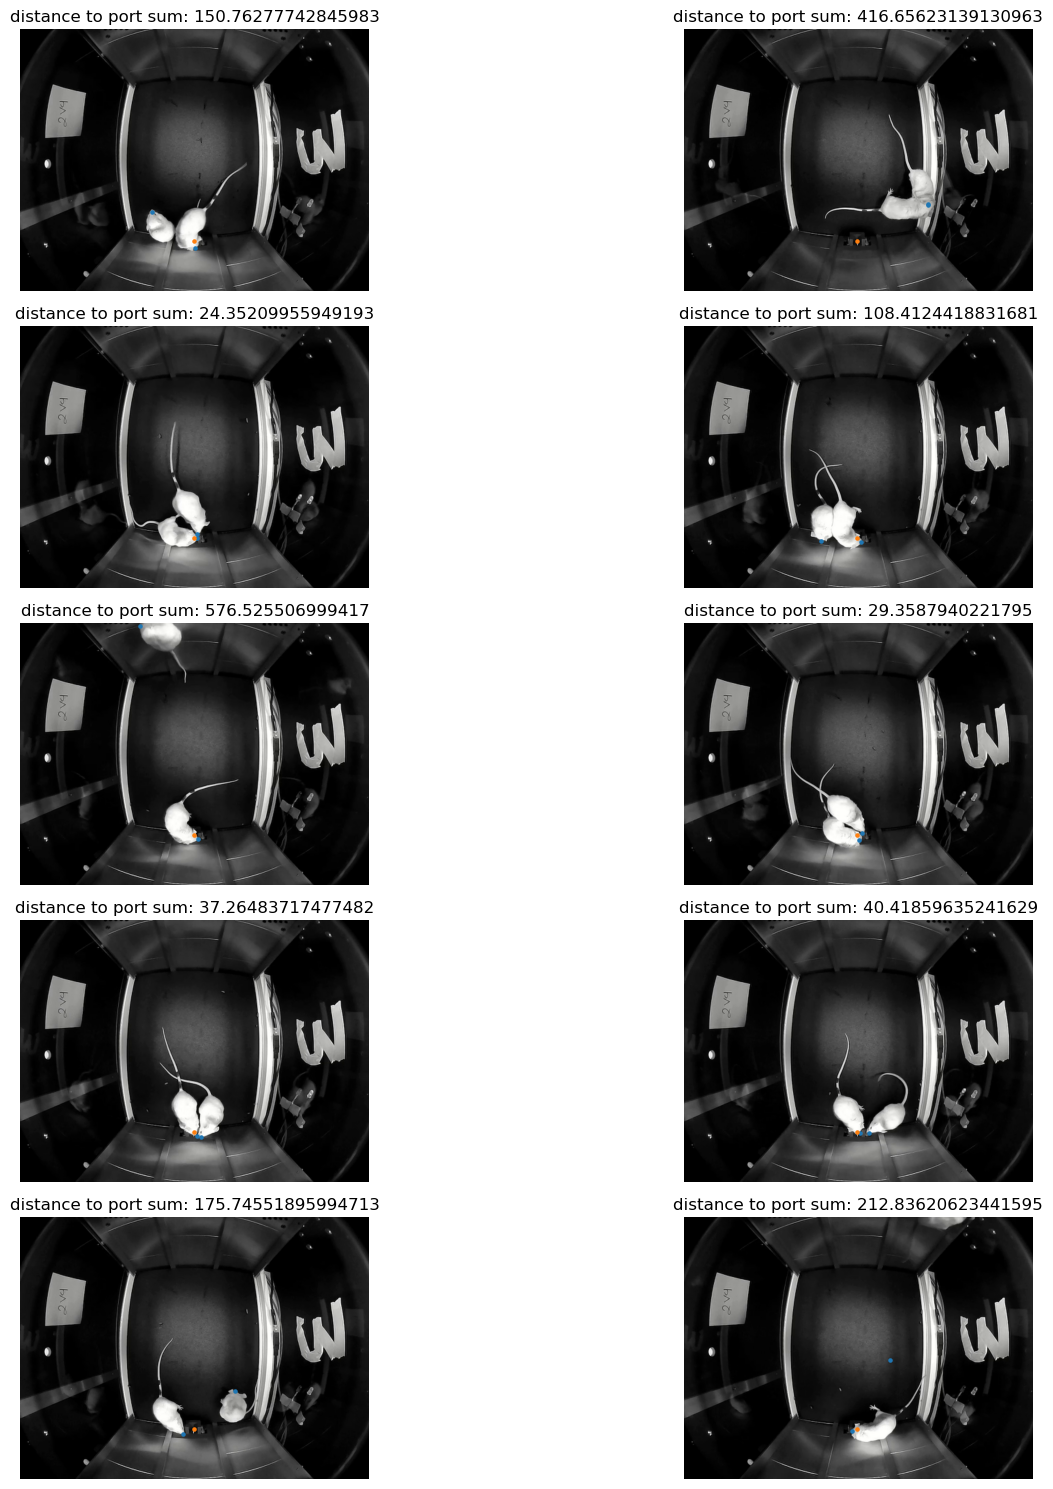

In [14]:

#Load your video using cv2.VideoCapture()
#pick random video file
cap = cv2.VideoCapture(r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos\10-03-22_Test_23_5-2v5-4.fixed.mp4')  # Replace 'your_video.mp4' with your video file
#insert video file base name 
file = '10-03-22_Test_23_5-2v5-4'
sleap = info[file]

#and pick feature 
feature = 'distance to port sum'
if not cap.isOpened(): 
    print("Could not open the video file!")
else:
    print("Video read successful!")
    success, image = cap.read()
    recording_df = df[df['Recording'] == file]
    my_array = np.array(recording_df[feature]) # Example array for demonstration
    frame_list = np.arange(1, sleap.locations.shape[0]+1)
    random_frames = np.random.choice(frame_list, size=10, replace=False)
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    for idx, frame_num in enumerate(random_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)  # Frame indexing starts from 0
        success, image = cap.read()
        if success:
            # Convert BGR image to RGB for display with matplotlib
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Plot on the respective subplot
            row = idx // 2  # Calculate subplot row
            col = idx % 2  # Calculate subplot column
            axs[row, col].imshow(frame_rgb)
            axs[row, col].scatter(
                #pick nodes that you want to visualize, last dimenison is mouse
                #0 = mouse 1 , 1 = mouse 2 
                sleap.locations[frame_num, sleap.node_dict['nose'], 0, :],
                sleap.locations[frame_num, sleap.node_dict['nose'], 1, :],
                s=5
            )
            axs[row, col].scatter(box_setup[file]['reward_port'][0],
                                  box_setup[file]['reward_port'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_left'][0],
            #                       box_setup[file]['bottom_left'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_right'][0],
            #                       box_setup[file]['bottom_right'][1],s=5)
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 1, :],
            #     s=5
            # )
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 1, :],
            #     s=5)
            axs[row, col].axis('off')  # Turn off axis labels and ticks
            axs[row, col].set_title(f"{feature}: {my_array[frame_num]}")
    plt.tight_layout()  # Adjust subplot layout
    plt.show()
cap.release()


# UMAPS

### Color dictionary for labels

In [12]:
def make_color_dict(column_name, df, cmap = 'gist_ncar'):
    unique_labels = df[column_name].unique()
    color_map = plt.cm.get_cmap(cmap, len(unique_labels))
    # Create a dictionary to map labels to colors
    label_color_dict = {label: color_map(i) for i, label in enumerate(unique_labels)}
    # Assign colors to each label based on the color map
    #colors = [label_color_dict[label] for label in recording_labels]
    #colors = np.array(colors)
    return label_color_dict

def show_palette(color_dict):
    colors = list(color_dict.values())
    palette = sns.color_palette(colors)
    sub_pallete_no = int(len(palette)//5)
    divided_palettes = [palette[i:i+5] for i in range(0, len(palette), 5)]  # Create 6 lists of 5 elements
    divided_palettes.append(palette[sub_pallete_no:])
    # Plotting color swatches for each label
    for color_palette in divided_palettes:
        sns.palplot(color_palette)  # Plotting color swatches for each sub-palette
        
        # Adding labels above the color swatches
        plt.xticks([])  # Hide x-axis ticks
        for color, label in zip(color_palette, list(color_dict.keys())):
            plt.text(color_palette.index(color), -0.5, label, ha='center', fontsize=8, rotation=45)

        plt.show()
recording_colors = make_color_dict('Recording', subsample_df)
strain_colors = {'C57': 'r', 'CD1':'b'}




## UMAP calls

In [13]:
subsample_df

thorax distances      mouse velocity sum     mouse velocity diff  \
0         408.4449068834765   4.875759638414025e-13  1.8523843593692647e-13   
3        408.44490688347656  1.3945576611048274e-13   7.746419943545955e-14   
6        408.44490688347673  1.1034667601096052e-13   5.411321242169659e-15   
9        408.44490688347685  2.5134058136159345e-13   5.314516767336618e-14   
12       408.44490688347577  2.6808022249097045e-13   7.089975766914401e-14   
...                     ...                     ...                     ...   
1832811   506.8905397528988      0.4971469037224223     0.49714690372216874   
1832814   506.8795783566124      0.5295461593127373      0.5295461593124615   
1832817  506.76755694806735      0.5458741328595103      0.5458741328592367   
1832820   506.4732504657891      0.5230590027517719      0.5230590027515356   
1832823    505.804214652594     0.46256673045606095      0.4625667304558911   

        orientation to port sum orientation to port diff distance to port sum  \
0             4.114290609883052        2.706663699849729     577.837885776614   
3            4.1142906098830485        2.706663699849731    577.8378857766137   
6             4.114290609883048        2.706663699849729    577.8378857766137   
9             4.114290609883047       2.7066636998497318    577.8378857766136   
12           4.1142906098830565       2.7066636998497184    577.8378857766155   
...                         ...                      ...                  ...   
1832811      0.3014569966200489       0.1493297490176404    527.8008214497895   
1832814     0.29977939192826464      0.15100735370942864    528.0645657649214   
1832817      0.3023078282326461      0.14847891740504804    528.1998379039411   
1832820      0.3077930074026052      0.14299373823509076    528.0580188692136   
1832823      0.3160791384348418      0.13470760720285502    527.6179566084195   

        distance to port diff thorax distances_zscore  \
0           473.0473660421544      2.0550194619619164   
3          473.04736604215447       2.055019461961917   
6           473.0473660421545      2.0550194619619186   
9          473.04736604215464      2.0550194619619195   
12          473.0473660421536      2.0550194619619107   
...                       ...                     ...   
1832811    499.09589204920644       2.865179760501852   
1832814     498.8321477340732       2.865089553472561   
1832817     498.6968755950535        2.86416767105742   
1832820      498.838694629781       2.861745669993533   
1832823    499.27875689057464      2.8562398264293902   

        mouse velocity sum_zscore mouse velocity diff_zscore  ...  \
0             -0.7936327099738277        -0.6478233911854179  ...   
3             -0.7936327099739303        -0.6478233911854575  ...   
6              -0.793632709973939        -0.6478233911854839  ...   
9             -0.7936327099738973        -0.6478233911854664  ...   
12            -0.7936327099738923          -0.64782339118546  ...   
...                           ...                        ...  ...   
1832811       -0.6471889964598446         -0.465317948498584  ...   
1832814       -0.6376452031299195       -0.45342399836038305  ...   
1832817       -0.6328354998763216         -0.447429906839299  ...   
1832820        -0.639556113747731        -0.4558054702574557  ...   
1832823       -0.6573752189811367        -0.4780125258617344  ...   

        orientation to port diff_zscore distance to port sum_zscore  \
0                    0.6911141181141811          2.2295545026361174   
3                    0.6911141181141822           2.229554502636115   
6                    0.6911141181141811           2.229554502636115   
9                    0.6911141181141828          2.2295545026361148   
12                   0.6911141181141741           2.229554502636126   
...                                 ...                         ...   
1832811             -0.9636269750826034          1.9409552031537467   
1832814

In [14]:
zscore_df = subsample_df.iloc[:,7:14]
zscore_df

thorax distances_zscore mouse velocity sum_zscore  \
0            2.0550194619619164       -0.7936327099738277   
3             2.055019461961917       -0.7936327099739303   
6            2.0550194619619186        -0.793632709973939   
9            2.0550194619619195       -0.7936327099738973   
12           2.0550194619619107       -0.7936327099738923   
...                         ...                       ...   
1832811       2.865179760501852       -0.6471889964598446   
1832814       2.865089553472561       -0.6376452031299195   
1832817        2.86416767105742       -0.6328354998763216   
1832820       2.861745669993533        -0.639556113747731   
1832823      2.8562398264293902       -0.6573752189811367   

        mouse velocity diff_zscore orientation to port sum_zscore  \
0              -0.6478233911854179             0.8902167997538446   
3              -0.6478233911854575             0.8902167997538429   
6              -0.6478233911854839             0.8902167997538425   
9              -0.6478233911854664             0.8902167997538422   
12               -0.64782339118546             0.8902167997538467   
...                            ...                            ...   
1832811         -0.465317948498584            -0.9063176980314742   
1832814       -0.45342399836038305            -0.9071081533747006   
1832817         -0.447429906839299            -0.9059168023987563   
1832820        -0.4558054702574557            -0.9033322905619201   
1832823        -0.4780125258617344            -0.8994280236144194   

        orientation to port diff_zscore distance to port sum_zscore  \
0                    0.6911141181141811          2.2295545026361174   
3                    0.6911141181141822           2.229554502636115   
6                    0.6911141181141811           2.229554502636115   
9                    0.6911141181141828          2.2295545026361148   
12                   0.6911141181141741           2.229554502636126   
...                                 ...                         ...   
1832811             -0.9636269750826034          1.9409552031537467   
1832814             -0.9625414690536633          1.9424764039998308   
1832817             -0.9641775117195137          1.9432566145314791   
1832820             -0.9677267358531557          1.9424386434009528   
1832823             -0.9730883357795916          1.9399004916947642   

        distance to port diff_zscore  
0                 2.1264345806963694  
3                 2.1264345806963694  
6                   2.12643458069637  
9                 2.1264345806963707  
12                 2.126434580696364  
...                              ...  
1832811           2.2969931372779286  
1832814           2.2952662123193517  
1832817            2.294380487700206  
1832820             2.29530907958492  
1832823           2.2981904857722286  

[610942 rows x 7 columns]

### Enhanced Clusterable UMAP

In [15]:
clusterable_embedding_zscore = umap.UMAP(
    n_neighbors= 14,
    min_dist=0,
    n_components=2,
    random_state=42
).fit_transform(zscore_df)

### Standard Embedding UMAP

In [16]:
standard_embedding_zscore = umap.UMAP(random_state=42).fit_transform(zscore_df)


In [28]:
subsample_df['embedding_zscore_x'] = clusterable_embedding_zscore[:,0]
subsample_df['embedding_zscore_y']= clusterable_embedding_zscore[:,1]
subsample_df['embedding_zscore_x_standard'] = standard_embedding_zscore[:,0]
subsample_df['embedding_zscore_y_standard'] = standard_embedding_zscore[:,1]

### Clustering Calls

In [29]:
hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=460000).fit_predict(clusterable_embedding_zscore)
kmeans_labels_zscore = cluster.KMeans(n_clusters=8).fit_predict(clusterable_embedding_zscore)
standard_hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=450000).fit_predict(standard_embedding_zscore)

raw_hdbscan_labels_zscore = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=450000).fit_predict(zscore_df)
kmeans_label_zscore = cluster.KMeans(n_clusters=8).fit_predict(zscore_df)


In [305]:
standard_kmeans_labels_zscore = cluster.KMeans(n_clusters=10).fit_predict(standard_embedding_zscore)

In [306]:
subsample_df['standard_kmeans_labels_zscore'] = standard_kmeans_labels_zscore
subsample_df['standard_hdbscan_labels_zscore'] =  standard_hdbscan_labels_zscore
subsample_df['enhanced_kmeans_labels_zscore'] = kmeans_labels_zscore
subsample_df['enhanced_hdbscan_labels_zscore'] = hdbscan_labels_zscore
subsample_df['raw_kmeans_labels_zscore'] = kmeans_label_zscore
subsample_df['raw_hdbscan_labels_zscore'] = raw_hdbscan_labels_zscore


In [278]:
# with open('subsample_df.pkl', 'wb') as file:
#      pickle.dump(subsample_df, file)
# with open('subsample_df.pkl', 'rb') as file:
#     subsample_df = pickle.load(file)

In [307]:
clustered_df = subsample_df
clustered_dataset = len(clustered_df) 
random_subsample = np.random.choice(clustered_dataset, size=(clustered_dataset//10), replace = False)
subsample_cluster_df = clustered_df.iloc[random_subsample]
trial_df = clustered_df[clustered_df['trial_indice'].astype(float) > 0]
clustered_df.columns

Index(['thorax distances', 'mouse velocity sum', 'mouse velocity diff',
       'orientation to port sum', 'orientation to port diff',
       'distance to port sum', 'distance to port diff',
       'thorax distances_zscore', 'mouse velocity sum_zscore',
       'mouse velocity diff_zscore', 'orientation to port sum_zscore',
       'orientation to port diff_zscore', 'distance to port sum_zscore',
       'distance to port diff_zscore', 'Strain', 'Recording', 'frame indice',
       'trial_indice', 'tube_test_elo', 'urine_marking_elo',
       'home_cage_observation_elo', 'reward_comp_elo', 'embedding_zscore_x',
       'embedding_zscore_y', 'embedding_zscore_x_standard',
       'embedding_zscore_y_standard', 'standard_kmeans_labels_zscore',
       'standard_hdbscan_labels_zscore', 'enhanced_kmeans_labels_zscore',
       'enhanced_hdbscan_labels_zscore', 'raw_kmeans_labels_zscore',
       'raw_hdbscan_labels_zscore'],
      dtype='object')

## Cluster plots

### Standard Embedding

In [32]:
plt.rcdefaults()
cluster_colors = make_color_dict('raw_kmeans_labels_zscore', clustered_df)

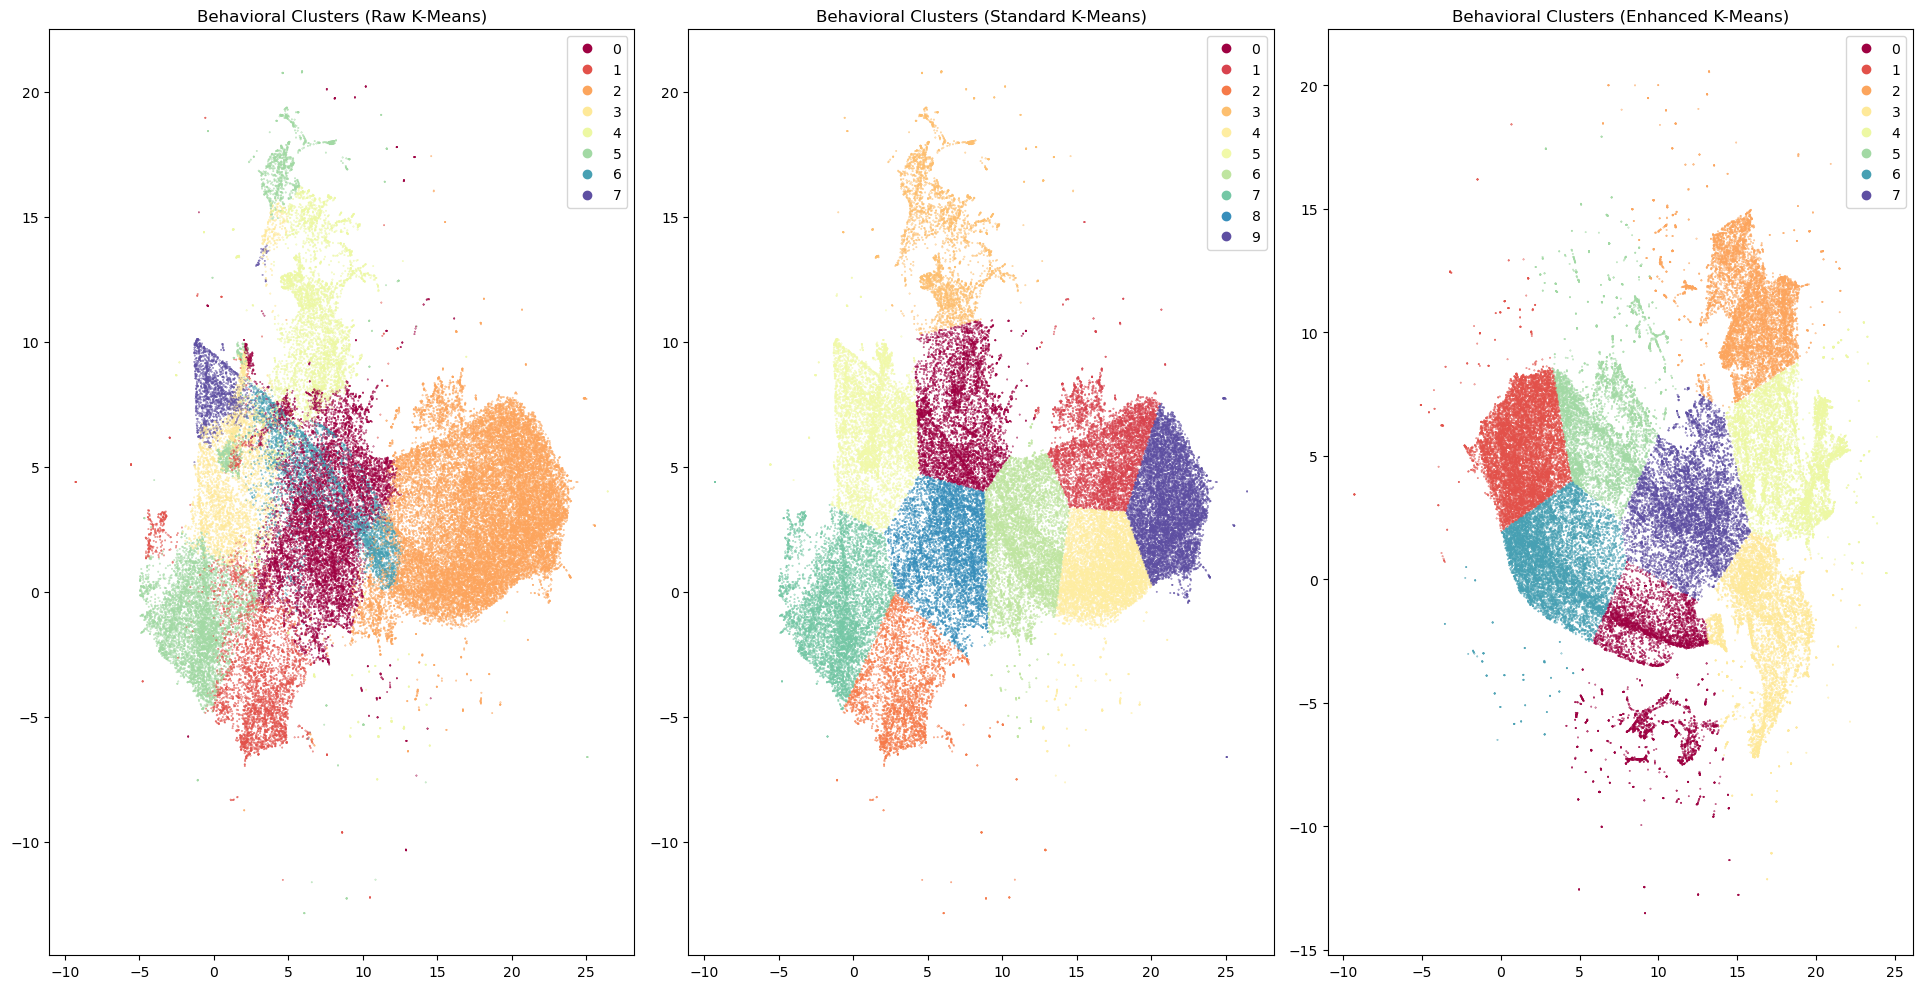

In [308]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

standard_clustered_zscore = subsample_df[subsample_df['standard_hdbscan_labels_zscore'] >= 0]
raw_clustered_zscore = subsample_df[subsample_df['raw_hdbscan_labels_zscore'] >= 0]

# Plot scatter plots on each subplot
scatter1 = axs[0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[0].set_title('Behavioral Clusters (Raw K-Means)')
axs[0].legend(*scatter1.legend_elements(), bbox_to_anchor=(1, 1))

scatter2 = axs[1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['standard_kmeans_labels_zscore'],
                             s=0.1,
                             cmap = 'Spectral')
axs[1].set_title('Behavioral Clusters (Standard K-Means)')
axs[1].legend(*scatter2.legend_elements(), bbox_to_anchor=(1, 1))

scatter3 = axs[2].scatter(subsample_cluster_df['embedding_zscore_x'],
                             subsample_cluster_df['embedding_zscore_y'],
                             c=subsample_cluster_df['enhanced_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[2].set_title('Behavioral Clusters (Enhanced K-Means)')
axs[2].legend(*scatter3.legend_elements(), bbox_to_anchor=(1, 1))



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

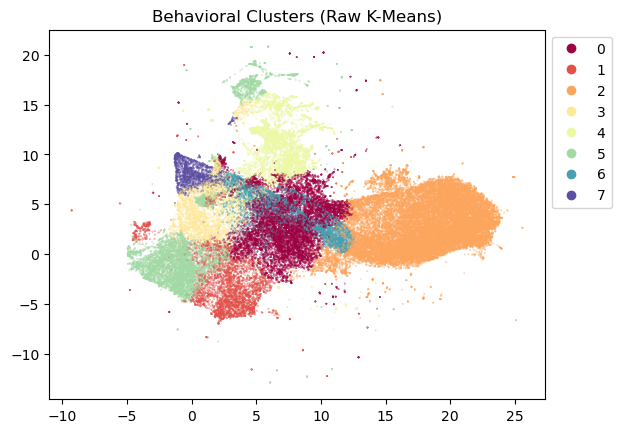

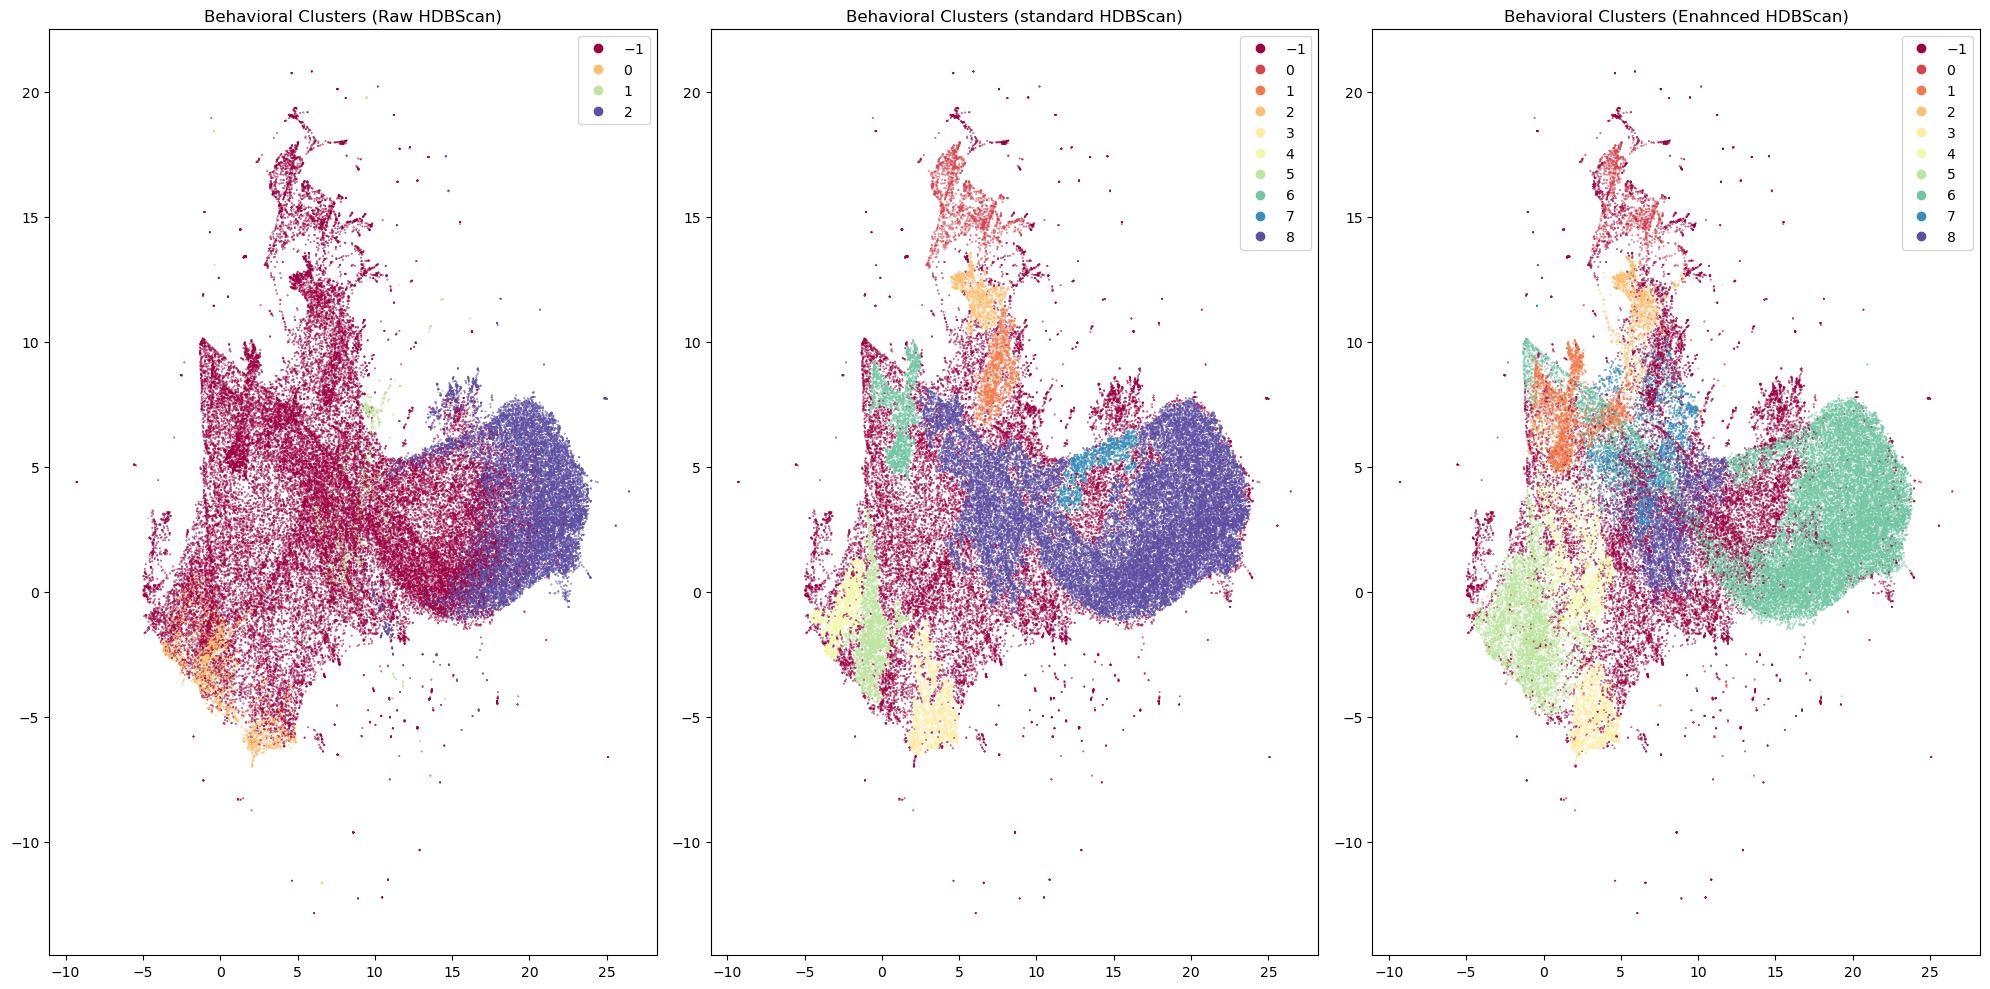

In [34]:
standard_clustered_zscore = subsample_df[subsample_df['standard_hdbscan_labels_zscore'] >= 0]
raw_clustered_zscore = subsample_df[subsample_df['raw_hdbscan_labels_zscore'] >= 0]

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

scatter1 = axs[0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[0].set_title('Behavioral Clusters (Raw HDBScan)')
axs[0].legend(*scatter1.legend_elements(), bbox_to_anchor=(1, 1))

scatter2 = axs[1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['standard_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[1].set_title('Behavioral Clusters (standard HDBScan)')
axs[1].legend(*scatter2.legend_elements(), bbox_to_anchor=(1, 1))


scatter3 = axs[2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['enhanced_hdbscan_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
axs[2].set_title('Behavioral Clusters (Enahnced HDBScan)')
axs[2].legend(*scatter3.legend_elements(), bbox_to_anchor=(1, 1))



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Feature overlay plots

ValueError: cannot convert float NaN to integer

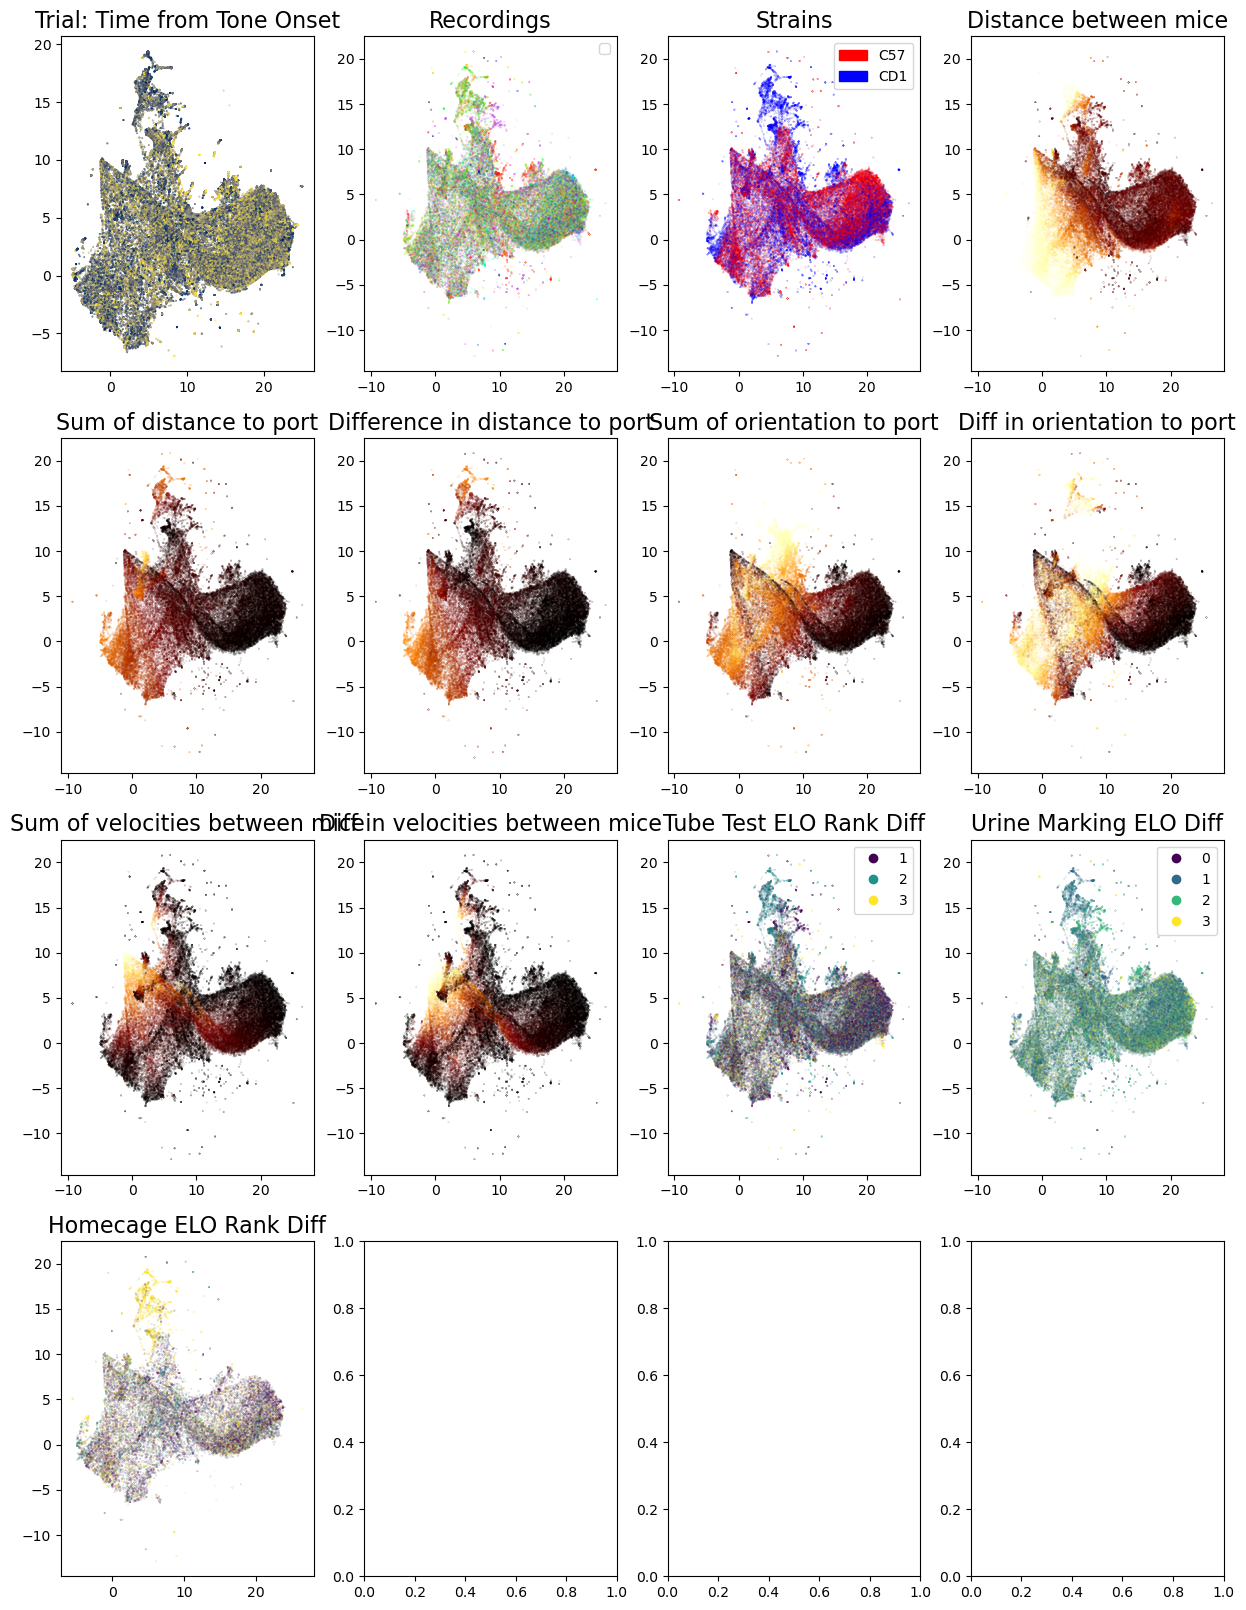

In [42]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(4, 4, figsize=(15, 20))
scatter1 = ax[0,0].scatter(trial_df['embedding_zscore_x_standard'],
            trial_df['embedding_zscore_y_standard'],
            c=trial_df['trial_indice'].astype(float),
            s=0.1,
            cmap='cividis')
ax[0,0].set_title('Trial: Time from Tone Onset', fontsize= 16)

scatter2 = ax[0,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['Recording'].map(recording_colors),
            label = subsample_cluster_df['Recording'],
            s=0.005)   
ax[0,1].set_title('Recordings', fontsize= 16)
legend2 = ax[0,1].legend(*scatter2.legend_elements(), bbox_to_anchor = (1,1))

scatter3 = ax[0,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['Strain'].map(strain_colors),
            label=subsample_cluster_df['Strain'],
            s=0.005)  
ax[0,2].set_title('Strains', fontsize= 16)
legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
legend3 = ax[0,2].legend(handles = legend_handles3, bbox_to_anchor = (1,1))

scatter4 = ax[0,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['thorax distances'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 400)  
ax[0,3].set_title('Distance between mice', fontsize= 16)

scatter5 = ax[1,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port sum_zscore'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 6)  
ax[1,0].set_title('Sum of distance to port', fontsize= 16)

scatter6 = ax[1,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port diff_zscore'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 6)  
ax[1,1].set_title('Difference in distance to port', fontsize= 16)

scatter7 = ax[1,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax=7)  
ax[1,2].set_title('Sum of orientation to port', fontsize= 16)

scatter8 = ax[1,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['orientation to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[1,3].set_title('Diff in orientation to port', fontsize= 16)

scatter9 = ax[2,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 20)  
ax[2,0].set_title('Sum of velocities between mice', fontsize= 16)

scatter10 = ax[2,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 12.5)  
ax[2,1].set_title('Diff in velocities between mice', fontsize= 16)

scatter11 = ax[2,2].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['tube_test_elo'].astype(float),
            s=0.005)  
ax[2,2].set_title('Tube Test ELO Rank Diff', fontsize= 16)
legend11 = ax[2,2].legend(*scatter11.legend_elements(), bbox_to_anchor = (1,1))


scatter12 = ax[2,3].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['urine_marking_elo'].astype(float),
            s=0.005)  
ax[2,3].set_title('Urine Marking ELO Diff', fontsize= 16)
legend12 = ax[2,3].legend(*scatter12.legend_elements(), bbox_to_anchor = (1,1))


scatter13 = ax[3,0].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['home_cage_observation_elo'].astype(float),
            s=0.005)  
ax[3,0].set_title('Homecage ELO Rank Diff', fontsize= 16)
legend13 = ax[3,0].legend(*scatter13.legend_elements(), bbox_to_anchor = (1,1))

scatter14 = ax[3,1].scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['reward_comp_elo'].astype(float),
            s=0.005)  
ax[3,1].set_title('Reward Comp ELO rank diff', fontsize= 16)
legend14 = ax[3,1].legend(*scatter14.legend_elements(), bbox_to_anchor = (1,1))




plt.colorbar(scatter1, ax=ax[0,0]) 
plt.colorbar(scatter4, ax=ax[0,3]) 
plt.colorbar(scatter5, ax=ax[1,0]) 
plt.colorbar(scatter6, ax=ax[1,1]) 
plt.colorbar(scatter7, ax=ax[1,2]) 
plt.colorbar(scatter8, ax=ax[1,3]) 
plt.colorbar(scatter9, ax=ax[2,0]) 
plt.colorbar(scatter10, ax=ax[2,1]) 


#legend_handles4 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
#legend3 = ax[3].legend(handles = legend_handles3)
plt.savefig('./feature_clusters.png')
plt.show()


([], <a list of 0 Text major ticklabel objects>)

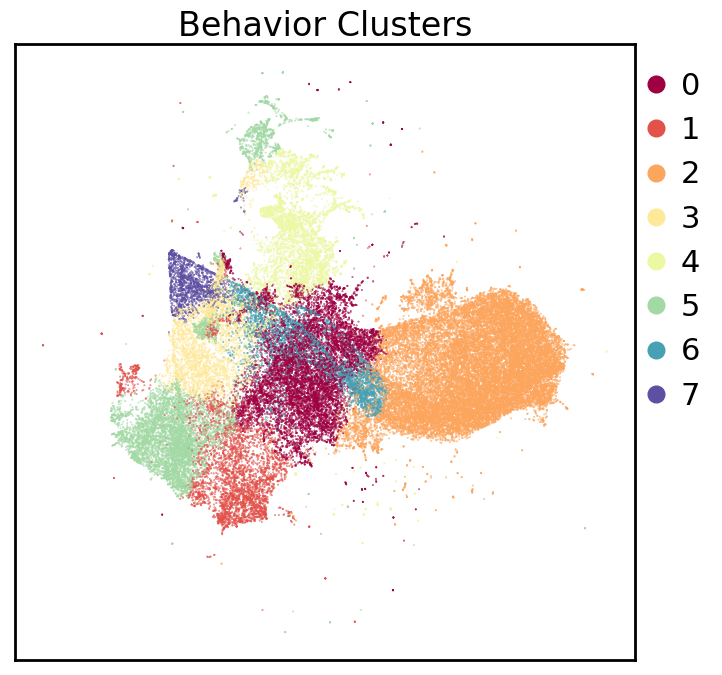

In [510]:
fig, ax = plt.subplots(figsize=(8, 8))
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
plt.title('Behavior Clusters', fontsize = 24)
legend = plt.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(.94, 1),
                    frameon = False,
                    fontsize = 22,
                    markerscale = 2,
                    ncol = 1,
                    handletextpad = -0.2,
                    columnspacing = 0.2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

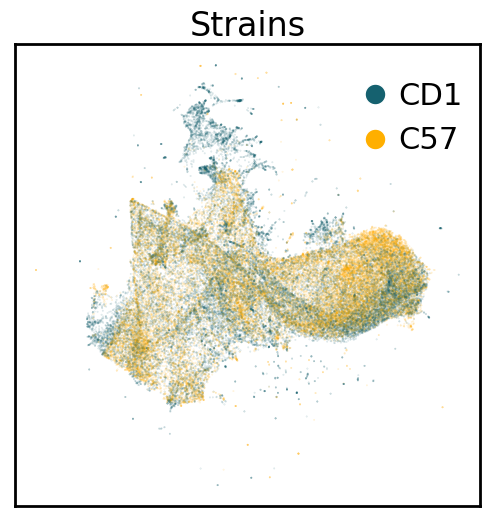

In [453]:
from matplotlib.lines import Line2D 
fig, ax = plt.subplots(figsize=(6, 6))
strain_colors = {'CD1': hex_2_rgb('#15616F'), 'C57': hex_2_rgb('#FFAF00')}
strain_alphas = {'CD1':0, 'C57':0.5}
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['Strain'].map(strain_colors),
            #label=subsample_cluster_df['Strain'],
            s=.1, alpha = .2)  
plt.title('Strains', fontsize= 24)
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                   for label, color in strain_colors.items()]
#legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
plt.legend(handles = legend_handles,
           bbox_to_anchor = (.65,.7),
           frameon= False,
           fontsize = 22,
           markerscale = 1.5,
           handletextpad=-.25)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

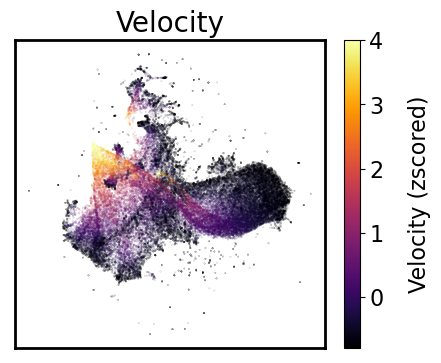

In [511]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['mouse velocity sum_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  
cbar = plt.colorbar()
plt.title('Velocity', fontsize= 20)
cbar.set_label(label = 'Velocity (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.labelpad = 18
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

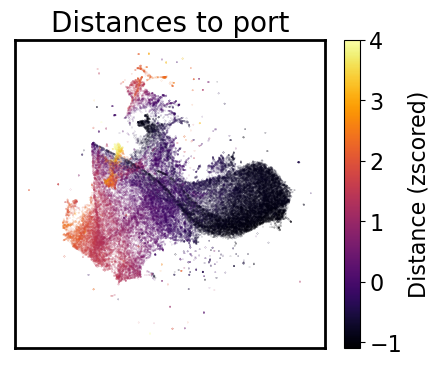

In [512]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
            subsample_cluster_df['embedding_zscore_y_standard'],
            c=subsample_cluster_df['distance to port sum_zscore'].astype(float),
            s=0.005, cmap = 'inferno', vmax = 4)  

plt.title('Distances to port', fontsize= 20)
cbar = plt.colorbar()
cbar.set_label(label = 'Distance (zscored)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

## Cluster Analysis

In [45]:
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

### Strain

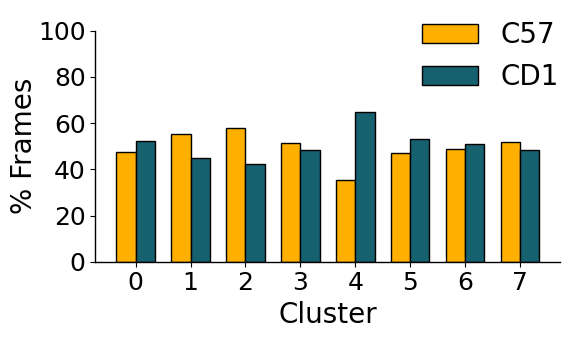

In [329]:
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','Strain'])
strain_counts = cluster_grouping['Strain'].value_counts().unstack() 
strain_percentages = strain_counts.div(strain_counts.sum(axis=1), axis=0) * 100

# Get the number of clusters
num_clusters = strain_counts.shape[0]

# Set the width of each bar
bar_width = 0.35

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters)

# Plot the bars for each strain next to each other
fig, ax = plt.subplots(figsize=(6, 3))
bar1 = ax.bar(cluster_indices - bar_width/2, strain_percentages.iloc[:, 0], 
              bar_width, label=strain_percentages.columns[0], 
              color = hex_2_rgb('#FFAF00'), edgecolor = 'k')
bar2 = ax.bar(cluster_indices + bar_width/2, strain_percentages.iloc[:, 1], 
              bar_width, label=strain_percentages.columns[1],
              color = hex_2_rgb('#15616F'), edgecolor = 'k')

# Add labels, title, and legend
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,100)
ax.set_ylabel('% Frames', fontsize = 20, labelpad = 0)
#ax.set_title('Strain Percentage per Cluster', fontsize = 24)
ax.set_xticks(cluster_indices)
ax.legend(frameon = False, fontsize = 20, bbox_to_anchor = (1.05,1.15))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

reward_comp_elo                1       2      3
raw_kmeans_labels_zscore                       
0                          41562   43245  17001
1                          19158   16012   6851
2                         113454  109754  34597
3                          14756   14451   4849
4                          13856   20306  12952
5                          30248   32027   9286
6                          17265   18193   5319
7                           7158    6448   2194
<class 'pandas.core.frame.DataFrame'>
[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473), (0.8862745098039215, 0.3176470588235294, 0.2901960784313726), (0.9882352941176471, 0.6470588235294118, 0.36470588235294116), (0.996078431372549, 0.9529411764705882, 0.6), (0.8941176470588236, 0.9725490196078431, 0.6392156862745098), (0.6352941176470588, 0.8509803921568627, 0.6431372549019608), (0.2784313725490196, 0.6274509803921569, 0.7019607843137254), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588

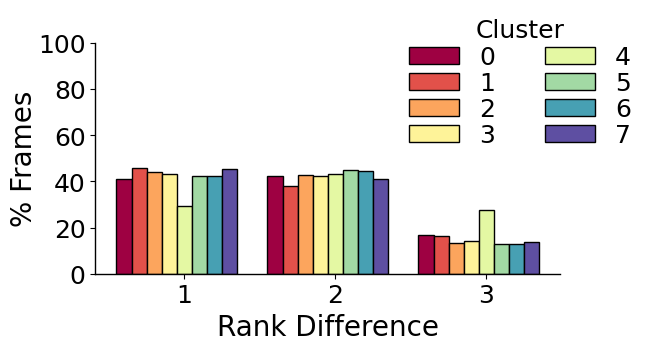

In [416]:
clustered_df['reward_comp_elo'] = pd.to_numeric(clustered_df['reward_comp_elo'], errors='coerce')

# Convert the column to integers
clustered_df['reward_comp_elo'] = clustered_df['reward_comp_elo'].astype(int)
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','reward_comp_elo'])
print(strain_counts)
strain_counts = cluster_grouping['reward_comp_elo'].value_counts().unstack()
strain_percentages = strain_counts.div(strain_counts.sum(axis=1), axis=0) * 100 


print(type(strain_percentages))

# Calculate percentages

# Set the width of each cluster
import matplotlib.cm as cm

# Get the number of clusters
num_clusters = strain_counts.shape[0]
num_rankdif = strain_counts.shape[1]

cluster_width = 0.8 / num_clusters

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters)
# Set the width of each bar

# Create an array of cluster indices
rank_indices = np.arange(num_rankdif)
bar_width = 0.1
# Plot the bars for each strain next to each other

colormap = cm.get_cmap('Spectral')  # Choose a colormap
colors = [hex_2_rgb('#9e0142'), hex_2_rgb('#e2514a'), hex_2_rgb('#fca55d'),
          hex_2_rgb('#fef399'), hex_2_rgb('#e4f8a3'), hex_2_rgb('#a2d9a4'),
          hex_2_rgb('#47a0b3'), hex_2_rgb('#5e4fa2')]
fig, ax = plt.subplots(figsize=(6, 3))
print(colors)
for i in cluster_indices:
    ax.bar(rank_indices + 1 + i * bar_width - 0.4, strain_percentages.iloc[i, :], 
              bar_width, edgecolor = 'k',
              color = colors[i], label = i)

# bar2 = ax.bar(rank_indices, strain_percentages.iloc[1, 0], 
#               bar_width, label=strain_percentages.iloc[1], edgecolor = 'k',
#               color = hex_2_rgb('#999999'))
# bar3 = ax.bar(rank_indices + bar_width, strain_percentages.iloc[2, :], 
#               bar_width, label=strain_percentages.iloc[2], edgecolor = 'k',
#               color = hex_2_rgb('#DDDDDD'))
# bar4 = ax.bar(rank_indices + bar_width, strain_percentages.iloc[3, :], 
#               bar_width, label=strain_percentages.iloc[2], edgecolor = 'k',
#               color = hex_2_rgb('#DDDDDD'))


# Add labels, title, and legend
ax.set_xlabel('Rank Difference', fontsize = 20)
ax.set_ylim(0,100)
ax.set_ylabel('% Frames', fontsize = 20, labelpad=0)
#ax.set_title('Reward Comp Rank Differences per Cluster', fontsize = 24, y=1.1)
ax.set_xticks(strain_percentages.columns)
legend = ax.legend(frameon=False, fontsize=18, title='Cluster', title_fontsize=18,
                 bbox_to_anchor = (1.2,1.2), labelspacing = 0.08, ncol = 2)

# Get the title text object from the legend
title_text = legend.get_title()
plt.subplots_adjust(wspace=0.1)
# Set the horizontal alignment to left
title_text.set_position((0,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

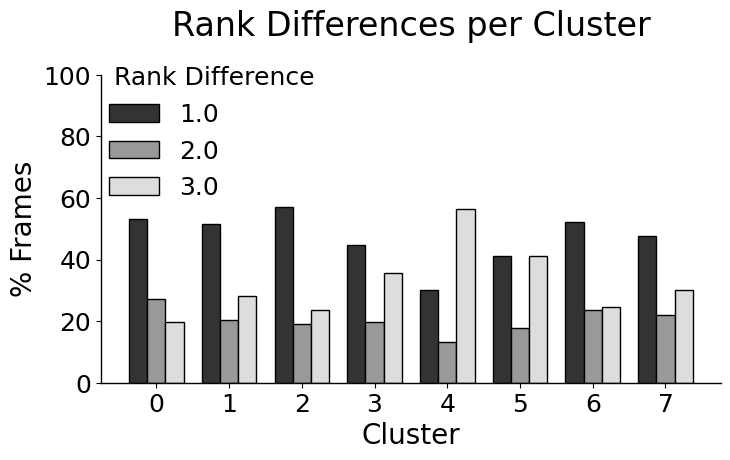

In [141]:
clustered_df['home_cage_observation_elo'] = pd.to_numeric(clustered_df['home_cage_observation_elo'], errors='coerce')

# Convert the column to integers
#clustered_df['home_cage_observation_elo'] = clustered_df['home_cage_observation_elo'].astype(int)
cluster_grouping = clustered_df.groupby(['raw_kmeans_labels_zscore','home_cage_observation_elo'])

strain_counts = cluster_grouping['home_cage_observation_elo'].value_counts().unstack()
strain_percentages = strain_counts.div(strain_counts.sum(axis=1), axis=0) * 100

# Get the number of clusters
num_clusters = strain_counts.shape[0]

# Set the width of each bar
bar_width = 0.25

# Create an array of cluster indices
cluster_indices = np.arange(num_clusters)

# Plot the bars for each strain next to each other
fig, ax = plt.subplots(figsize=(8, 4))
bar1 = ax.bar(cluster_indices - bar_width, strain_percentages.iloc[:, 0], 
              bar_width, label=strain_percentages.columns[0], edgecolor = 'k',
              color = hex_2_rgb('#333333'))
bar2 = ax.bar(cluster_indices, strain_percentages.iloc[:, 1], 
              bar_width, label=strain_percentages.columns[1], edgecolor = 'k',
              color = hex_2_rgb('#999999'))
bar3 = ax.bar(cluster_indices + bar_width, strain_percentages.iloc[:, 2], 
              bar_width, label=strain_percentages.columns[2], edgecolor = 'k',
              color = hex_2_rgb('#DDDDDD'))

# Add labels, title, and legend
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylim(0,100)
ax.set_ylabel('% Frames', fontsize = 20)
ax.set_title('Rank Differences per Cluster', fontsize = 24, y=1.1)
ax.set_xticks(cluster_indices)
legend = ax.legend(frameon=False, fontsize=18, title='Rank Difference', title_fontsize=18,
                   bbox_to_anchor = (.3,1.1))

# Get the title text object from the legend
title_text = legend.get_title()

# Set the horizontal alignment to left
title_text.set_position((50,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['bottom'].set_linewidth(1)  # X-axis
plt.gca().spines['left'].set_linewidth(1) 
# Show plot
plt.show()

In [154]:
counts = clustered_df['home_cage_observation_elo'].value_counts(dropna=False)
counts


home_cage_observation_elo
NaN    353631
1.0    130091
3.0     74584
2.0     52636
Name: count, dtype: int64

In [153]:

counts = clustered_df['tube_test_elo'].value_counts(dropna=False)
counts

tube_test_elo
1.0    313022
2.0    204685
3.0     93235
Name: count, dtype: int64

In [155]:
counts = clustered_df['urine_marking_elo'].value_counts(dropna=False)
counts

urine_marking_elo
1.0    334917
2.0    167442
3.0     90035
0.0     18548
Name: count, dtype: int64

In [156]:
counts = clustered_df['reward_comp_elo'].value_counts(dropna=False)
counts

reward_comp_elo
2    260436
1    257457
3     93049
Name: count, dtype: int64

Text(0, 0.5, 'Number of Frames')

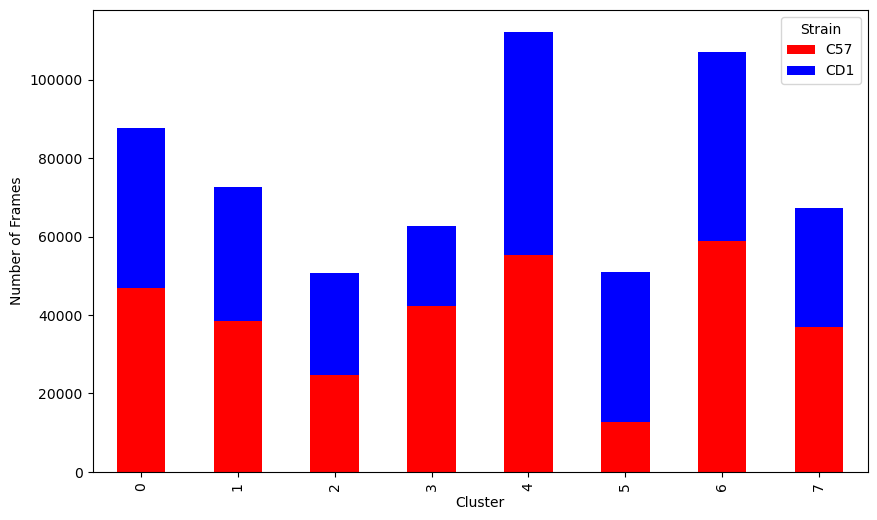

In [64]:
cluster_grouping = clustered_df.groupby(['standard_kmeans_labels_zscore','Strain'])
strain_counts = cluster_grouping['Strain'].value_counts().unstack()
strain_counts.plot(kind='bar', stacked=True, color = ['r','b'],figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')

### Trial


<Figure size 640x480 with 0 Axes>

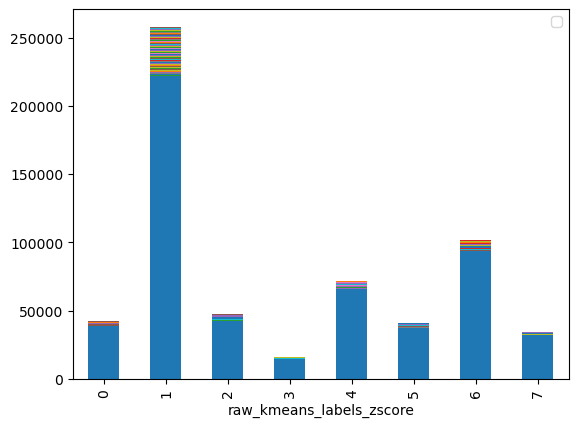

In [53]:
cluster_grouping_trial = subsample_df.groupby(['raw_kmeans_labels_zscore','trial_indice'])

trial_counts = cluster_grouping_trial['trial_indice'].value_counts().unstack()
plt.figure()
trial_counts.plot(kind='bar', stacked=True)    
plt.legend([]) 

Text(0.5, 1.0, 'Trial Time per cluster')

<Figure size 640x480 with 0 Axes>

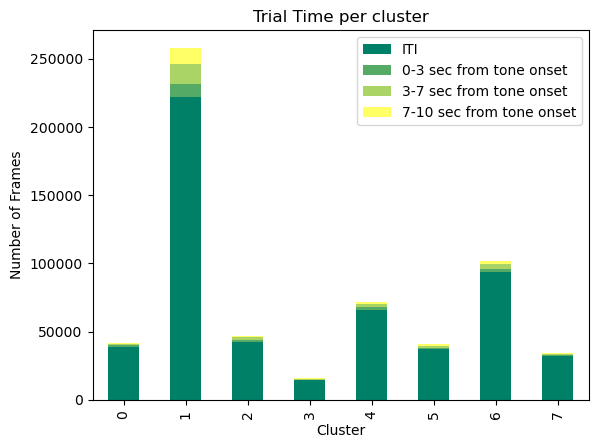

In [55]:
def categorize_trial_indices(value):
    value = float(value)
    if value == 0:
        return 'ITI'
    elif 0 < value <= 3:
        return '0-3 sec from tone onset'
    elif 3 < value <= 7:
        return '3-7 sec from tone onset'
    elif 7 < value <= 10:
        return '7-10 sec from tone onset'
    else:
        return None  
    

# Assign values based on the ranges
subsample_df['simplified_trial_indice'] = subsample_df['trial_indice'].apply(lambda x: categorize_trial_indices(x))
trial_colors = make_color_dict('simplified_trial_indice', subsample_df, 'summer')

cluster_grouping_trial = subsample_df.groupby(['raw_kmeans_labels_zscore','simplified_trial_indice'])

trial_counts = cluster_grouping_trial['simplified_trial_indice'].value_counts().unstack()
trial_counts = trial_counts[['ITI','0-3 sec from tone onset',
 '3-7 sec from tone onset',
 '7-10 sec from tone onset'
 ]]


plt.figure()
trial_counts.plot(kind='bar', stacked=True, color = trial_colors)    
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')
plt.title('Trial Time per cluster')


Text(0.5, 1.0, 'Trial Time per cluster')

<Figure size 640x480 with 0 Axes>

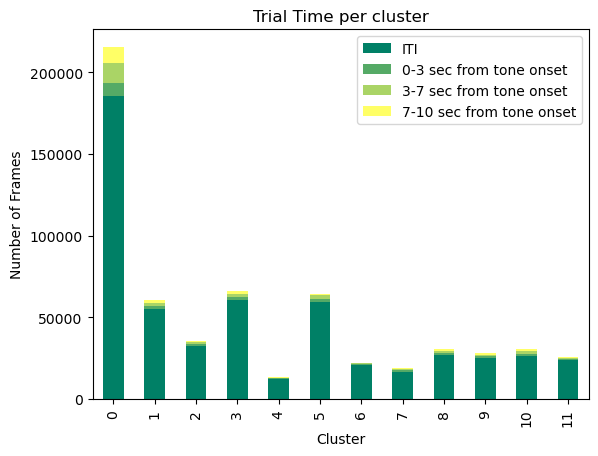

In [404]:

def categorize_trial_indices(value):
    value = float(value)
    if value == 0:
        return 'ITI'
    elif 0 < value <= 3:
        return '0-3 sec from tone onset'
    elif 3 < value <= 7:
        return '3-7 sec from tone onset'
    elif 7 < value <= 10:
        return '7-10 sec from tone onset'
    else:
        return None  
    

# Assign values based on the ranges
clustered_df['simplified_trial_indice'] = clustered_df['trial_indice'].apply(lambda x: categorize_trial_indices(x))
trial_colors = make_color_dict('simplified_trial_indice', clustered_df, 'summer')

cluster_grouping_trial = clustered_df.groupby(['raw_kmeans_labels','simplified_trial_indice'])

trial_counts = cluster_grouping_trial['simplified_trial_indice'].value_counts().unstack()
trial_counts = trial_counts[['ITI','0-3 sec from tone onset',
 '3-7 sec from tone onset',
 '7-10 sec from tone onset'
 ]]


plt.figure()
trial_counts.plot(kind='bar', stacked=True, color = trial_colors)    
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')
plt.title('Trial Time per cluster')


## GIF Creation

In [309]:
def cluster_gifs(all_cluster_df, cluster_label, gif_length,vid_folder, output_directory):
    create_output_directory(output_directory)
    no_clusters = len(all_cluster_df[cluster_label].unique())
    i = 1
    for cluster in all_cluster_df[cluster_label].unique():
        print(f'working on {i} out of {no_clusters} cluster gifs')
        cluster_df = all_cluster_df[all_cluster_df[cluster_label] == cluster]
        random_indices = np.random.choice(len(cluster_df), size=gif_length*30, replace=False)
        gif_df = cluster_df.iloc[random_indices]
        #gif_df.to_excel(os.path.join('tester.xlsx', output_directory))
        grouped = gif_df.groupby('Recording')['frame indice'].apply(list).reset_index()
        frames_df = grouped.apply(lambda row: extract_frames(row['Recording'], row['frame indice'], vid_folder), axis = 1)
        create_gif(cluster, frames_df, output_directory)
        i+=1

def find_vid(vid_name, folder):
    ending = ".mp4"
    for filename in os.listdir(folder):
        if filename.endswith(ending) and vid_name in filename:
            video_path = os.path.join(folder, filename)
    return video_path

def extract_frames(vid_name, frame_list, directory):
    # Open the video file
    video_path = find_vid(vid_name, directory)
    cap = cv2.VideoCapture(video_path)
    frames = []
    for frame_index in frame_list:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(float(frame_index))-1)
        success, frame = cap.read()
        if success:
            resized_frame = cv2.resize(frame, (640, 480))
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames
        
def create_gif(cluster, df, output_directory):
    gif_frames = []
    for recording in range(len(df.index)):
        row = df.loc[recording]
        i = 0
        for frame in row:
            resized_frame = cv2.resize(frame, (640, 480))
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            gif_frames.append(frame_rgb)
            i +=1
    gif_path = os.path.join(output_directory, f"cluster{cluster}.gif")
    imageio.mimsave(gif_path, gif_frames, format='GIF', duration=3)

def create_output_directory(output_directory):
    """
    Create the output directory if it does not exist.

    Parameters:
        output_dir (str): The path of the output directory to be created.
    """
    # Check if the directory exists
    if not os.path.exists(output_directory):
        try:
            # Create the directory
            os.makedirs(output_directory)
            print(f"Output directory '{output_directory}' created successfully.")
        except OSError as e:
            print(f"Error: Could not create output directory '{output_directory}': {e}")
    else:
        print(f"Output directory '{output_directory}' already exists.")


vid_folder = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos'
output_directory = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\results\wo_orientation_bwmice\cluster_gifs_zscore_standard'
cluster_gifs(subsample_df, cluster_label = 'standard_kmeans_labels_zscore', gif_length = 5, vid_folder=vid_folder, output_directory=output_directory)

   

Output directory 'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\results\wo_orientation_bwmice\cluster_gifs_zscore_standard' already exists.
working on 1 out of 10 cluster gifs
working on 2 out of 10 cluster gifs
working on 3 out of 10 cluster gifs
working on 4 out of 10 cluster gifs
working on 5 out of 10 cluster gifs
working on 6 out of 10 cluster gifs
working on 7 out of 10 cluster gifs
working on 8 out of 10 cluster gifs
working on 9 out of 10 cluster gifs
working on 10 out of 10 cluster gifs


## Ethogram

In [71]:
# goal is to create a bar graph for one recording 
file = '10-03-22_Test_23_5-2v5-4'
tester_df = clustered_df[clustered_df['Recording'] == file]
tester_df[['frame indice', 'raw_kmeans_labels_zscore']]

frame indice  raw_kmeans_labels_zscore
502329          2.0                         1
502332          5.0                         1
502335          8.0                         1
502338         11.0                         1
502341         14.0                         1
...             ...                       ...
557955      55628.0                         3
557958      55631.0                         3
557961      55634.0                         3
557964      55637.0                         3
557967      55640.0                         3

[18547 rows x 2 columns]

In [73]:
def get_indices(df, cluster_label):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item. 
    
    Args (1):
        repeated_items_list: list, list of repeated items 
    
    Returns:
        item_indices: list of tuples, where the first element is the first index 
                      of an item, and the second element is the last index of that 
                      item 
    """
    is_first = True
    item_indices = {}
    durations = {}
    for i in range(len(df)):
        if is_first:
            current_item = df.iloc[i][cluster_label]
            start_index = df.iloc[i]['frame indice']
            current_recording = df.iloc[i]['Recording']
            start_index = float(start_index)/30/60
            is_first = False
        if df.iloc[i]['Recording'] != current_recording:
            end_index = df.iloc[i-1]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
            current_recording = df.iloc[i]['Recording']
            start_index = df.iloc[i]['frame indice']
            start_index = float(start_index)/30/60
        if i == (len(df)-1):
            end_index = df.iloc[i]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
        if (not is_first) & (df.iloc[i]['Recording'] == current_recording):
            if df.iloc[i][cluster_label] != current_item:
                end_index = df.iloc[i]['frame indice']
                stop_index = df.iloc[i-1]['frame indice']
                stop_index = float(stop_index)/30/60
                end_index = float(end_index)/30/60
                if current_item in item_indices.keys():
                    indice_list = item_indices[current_item]
                    indice_list.append([start_index,stop_index])
                    durations[current_item].append(end_index - start_index)
                    item_indices[current_item] = indice_list
                else: 
                    item_indices[current_item] = [[start_index, stop_index]]
                    durations[current_item] = [end_index - start_index]
                start_index = df.iloc[i]['frame indice']
                start_index = float(start_index)/30/60
                current_item = df.iloc[i][cluster_label] 
    return item_indices, durations

cluster_dict, durations = get_indices(clustered_df, 'raw_kmeans_labels_zscore')

recording_cluster_dict, tester_durations = get_indices(tester_df, 'raw_kmeans_labels_zscore')

  

In [74]:
avg_durations = {}
for cluster, duration in tester_durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh, min_beh, no_events]
    

tester_cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
tester_cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)', 'Min(s)', 'Number of events']
tester_cluster_info

Average Duration (s)  Median (s)  Max (s)  Min(s)  Number of events
1              1.637731        0.85     25.6     0.1               432
6              0.918770        0.40     10.3     0.1               309
5              0.353195        0.30      1.5     0.1               532
7              0.269302        0.20      1.7     0.1               430
4              1.325253        0.80     11.2     0.1               198
0              0.596875        0.40      4.5     0.1               192
3              0.403704        0.40      1.2     0.1               162
2              0.867407        0.40     12.8     0.1               135

In [75]:
avg_durations = {}
for cluster, duration in durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh]#, min_beh]#, no_events]
    

cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)'] #'Min(s)']#, 'Number of events']
cluster_info

Average Duration (s)  Median (s)  Max (s)
4              1.385365         0.8     22.8
3              0.386537         0.4      1.5
7              0.320258         0.2      4.3
0              0.809634         0.4     32.2
5              0.347410         0.3      2.3
1              2.493082         1.2     62.4
2              0.987945         0.4     73.8
6              1.253917         0.6     35.5

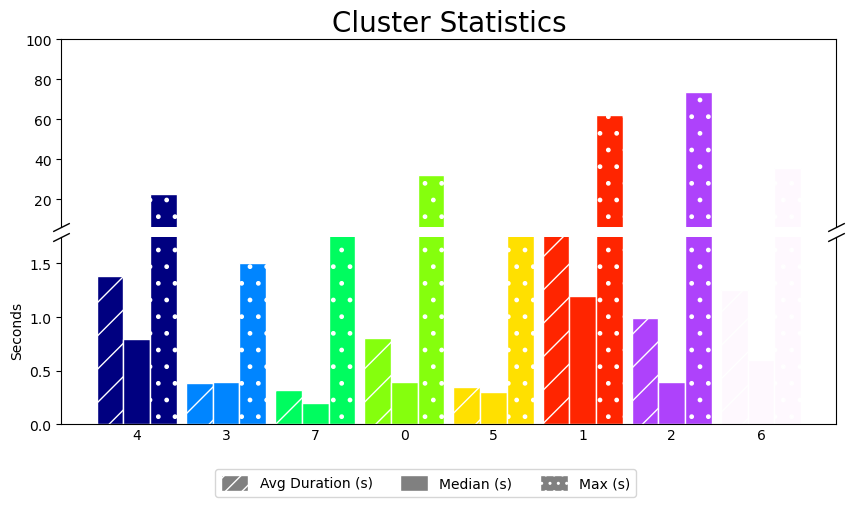

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,5), sharex=True, facecolor='white')
fig.subplots_adjust(hspace=0.05) 
import matplotlib.patches as mpatches

colors = list(cluster_colors.values())
fills = ['/','','.']*10
# Loop through each cluster (index) and plot the bars
for i, cluster in enumerate(cluster_info.index):
    cluster_data = cluster_info.loc[cluster]
    bar_width = 0.3
    x_positions = [i + bar_width * j for j in range(len(cluster_data))]
    for j, (x, value) in enumerate(zip(x_positions, cluster_data)):
        hatch_pattern = fills[j % len(fills)]  # Use modulo to cycle through fill patterns
        # Plot on the first subplot (0-1 on y-axis)
        ax1.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        # Plot on the second subplot (0-1 on y-axis)
        ax2.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        if j == len(x_positions) // 2:  # Assuming the middle bar is at index len(x_positions) // 2
            ax1.text(x, -2, f'{cluster}', ha='center', va='center')
            ax2.text(x, -0.1, f'{cluster}', ha='center', va='center')
    #ax1.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
    #ax2.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
# ax2.set_xticks([j + 1.5 * bar_width * i for i in range(len(cluster_info.columns)) for j in range(len(cluster_info))])
# ax2.set_xticklabels([col for col in cluster_info.columns for _ in range(len(cluster_info))], rotation=45, ha='right')
ax1.set_ylim(6, 100)  # outliers only
ax2.set_ylim(0, 1.75)  # most of the data

# hide the spines between ax and ax2
 # don't put tick labels at the top

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Set labels and title


ax2.set_ylabel('Seconds')
ax1.set_title('Cluster Statistics', fontsize = 20)

# Add legend

cluster_labels = []
for cluster, color in cluster_colors.items():
    cluster_labels.append(mpatches.Patch(facecolor=color,  label=cluster))
                          
#ax1.legend(handles = cluster_labels, bbox_to_anchor=(.9,-1.1), ncol=10)                   
patch_max = mpatches.Patch(facecolor='gray', hatch='..', label='Max (s)', edgecolor='white')
patch_avg = mpatches.Patch(facecolor='gray', hatch='//', label='Avg Duration (s)',edgecolor='white')
patch_median = mpatches.Patch(facecolor='gray', hatch='', label='Median (s)',edgecolor='white')

# Plotting empty bars to display the legend
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   


# Create the legend
ax2.legend(handles=[ patch_avg, patch_median, patch_max], bbox_to_anchor=(.75,-.2), ncol= 3, handleheight=1.5)
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()



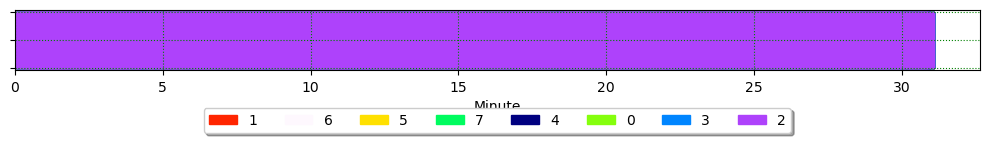

In [84]:
fig, axs = plt.subplots(figsize=(10, 2), nrows=1, ncols=1, sharex=True)   
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
i = 0
bar_height = 1
for cluster_label in y_labels:
    start_stops = cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts,stops]
# color
    bar_color = cluster_colors[cluster_label]
    axs.barh(width = stops - starts,
             y = 1,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
        )
    i += 1
#axs.set_ylim(bottom=0, top=(max_len * par1) + par1)
pos = np.arange(par1, max_len * par1 + par1 + 1, par1)
#axs.set_yticks(pos[: len(y_labels)])
axs.set_yticklabels("")
#axs.set_xlim((0,1))
#axs.set_ylabel("Cluster")
axs.grid(color="g", linestyle=":")
axs.set_xlabel("Minute")
axs.invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=10)
plt.tight_layout()
plt.show()

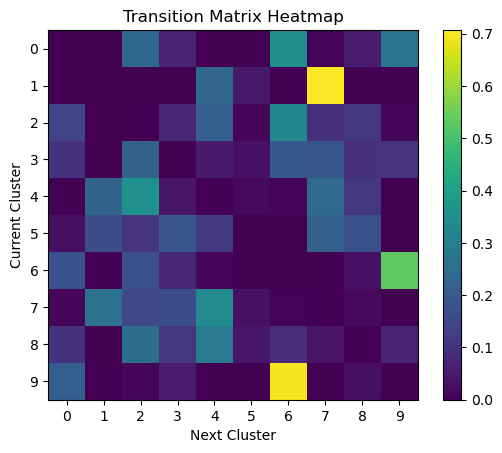

In [ ]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_states = len(states)
# Example sequence of transitions
transitions = np.array(clustered_df['kmeans_label'])
transitions = transitions[np.append([True], np.diff(transitions) != 0)]
# Create a transition matrix
transition_matrix = np.zeros((len(states), len(states)))

# Populate the transition matrix
for i in range(len(transitions) - 1):
    current_state = transitions[i]
    next_state = transitions[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.title('Transition Matrix Heatmap')
plt.xticks(np.arange(num_states), np.arange(num_states))

# Set y-axis ticks and labels
plt.yticks(np.arange(num_states), np.arange(num_states))
# Show the plot
plt.show()

No handles with labels found to put in legend.


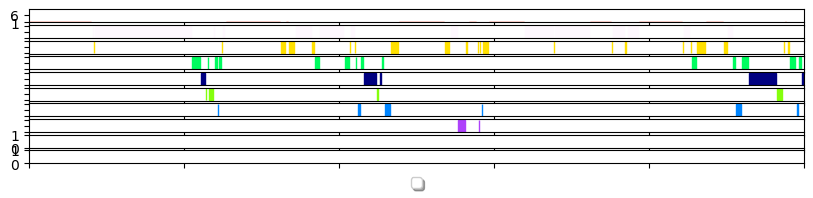

In [88]:
fig, axs = plt.subplots(figsize=(10, 2), nrows=10, ncols=1, sharex=True)
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
i = 0
bar_height = 1

for cluster_label in y_labels:
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]
    # color
    bar_color = cluster_colors[cluster_label]
    axs[i].barh(
        0,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )
    axs[i].set_xticklabels('')
    axs[i].set_yticklabels('')
    axs[i].set_xlim((0,1))
    i += 1

axs[0].set_ylim(bottom=0, top=(max_len * par1) + par1)
pos = np.arange(par1, max_len * par1 + par1 + 1, par1)

# Adjust y-axis ticks and labels
#axs[0].set_yticks(pos[: len(y_labels)])
axs[0].set_yticklabels(y_labels)  # Use the cluster labels as y-axis tick labels

# axs[0].set_ylabel("Cluster")
# axs[0].grid(color="g", linestyle=":")
# axs[0].set_xlabel("Minute")
# axs[0].invert_yaxis()


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=10)
plt.tight_layout()
plt.show()

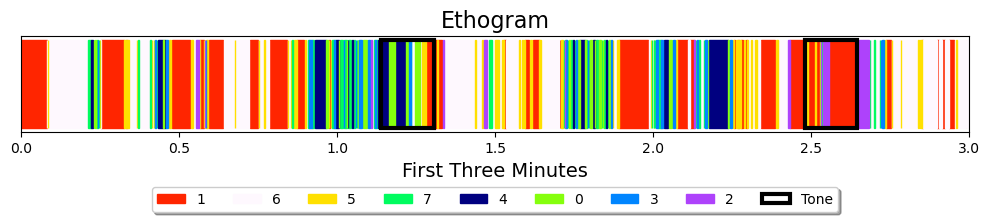

In [86]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("First Three Minutes", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 1.14, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.barh(1, .167, left = 2.48, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3)
#1.14277778,  2.47611111
ax.set_xlim((0,3))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

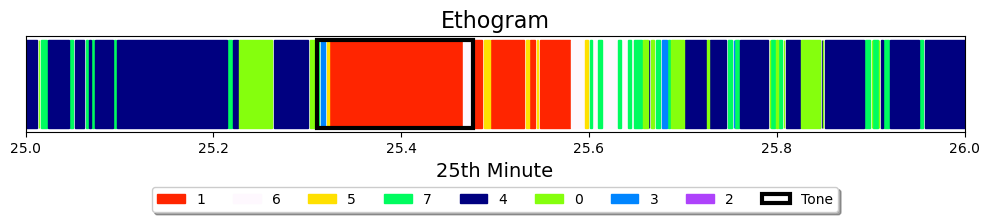

In [87]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 25.31, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.set_xlim((25,26))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

In [329]:
tester_tones = tone_times_df[tone_times_df['File Name'] ==file]
tester_tones

File Name Frame Start  FPS Strain  \
22  10-03-22_Test_23_5-2v5-4        2057   29    CD1   

                                       all_tone_frame  
22  [2057, 4457, 7157, 9557, 11807, 14807, 17657, ...

In [330]:
tester_tones = list(tester_tones['all_tone_frame'])
tester_tones = tester_tones[0]
tester_tones = np.array(tester_tones) / 30 / 60


In [331]:
tester_tones

array([ 1.14277778,  2.47611111,  3.97611111,  5.30944444,  6.55944444,
        8.22611111,  9.80944444, 11.30944444, 12.64277778, 14.14277778,
       15.80944444, 17.30944444, 19.30944444, 20.80944444, 22.22611111,
       23.72611111, 25.30944444, 27.30944444, 28.64277778, 30.22611111,
       31.55944444, 33.05944444, 34.39277778, 35.64277778, 37.30944444,
       38.89277778, 40.39277778, 41.72611111, 43.22611111, 44.89277778,
       46.39277778, 48.39277778, 49.89277778, 51.30944444, 52.80944444,
       54.39277778, 55.89277778, 57.22611111, 58.72611111, 60.39277778,
       61.89277778, 63.39277778, 64.89277778, 66.39277778, 67.89277778,
       69.39277778, 70.89277778, 72.39277778, 73.89277778, 75.39277778,
       76.89277778, 78.39277778, 79.89277778, 81.39277778, 82.89277778,
       84.39277778, 85.89277778, 87.39277778, 88.89277778, 90.39277778])

### Raw clustering Stats


In [378]:
# goal is to create a bar graph for one recording 
file = '10-03-22_Test_23_5-2v5-4'
tester_df = clustered_df[clustered_df['Recording'] == file]
tester_df[['frame indice', 'raw_kmeans_labels']]

frame indice  raw_kmeans_labels
502329          2.0                  1
502332          5.0                  1
502335          8.0                  1
502338         11.0                  1
502341         14.0                  1
...             ...                ...
557955      55628.0                  5
557958      55631.0                  5
557961      55634.0                  5
557964      55637.0                  5
557967      55640.0                  5

[18547 rows x 2 columns]

In [379]:
raw_cluster_dict, raw_durations = get_indices(clustered_df, 'raw_kmeans_labels')

raw_recording_cluster_dict, raw_tester_durations = get_indices(tester_df, 'raw_kmeans_labels')

In [381]:
avg_durations = {}
for cluster, duration in raw_durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh]#, min_beh]#, no_events]
    

cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)'] #'Min(s)']#, 'Number of events']
cluster_info

Average Duration (s)  Median (s)  Max (s)
4              1.168590         0.6     18.3
8              0.263044         0.2      3.1
5              0.320414         0.3      1.3
6              0.964765         0.3     22.0
2              0.690744         0.3     26.9
7              0.508374         0.2     22.7
0              0.256560         0.2      1.4
1              1.800796         0.7     62.6
9              0.911510         0.4     66.4
3              0.654481         0.2     35.3

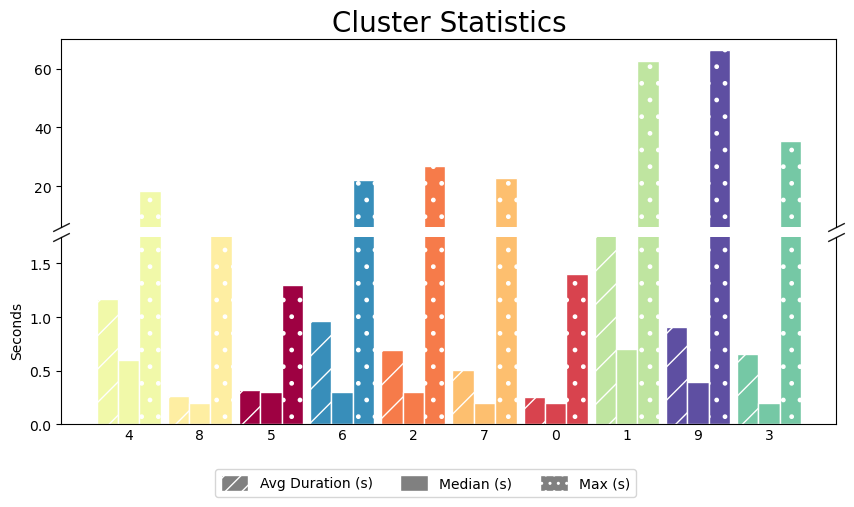

In [386]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,5), sharex=True, facecolor='white')
fig.subplots_adjust(hspace=0.05) 
import matplotlib.patches as mpatches

colors = list(cluster_colors.values())
fills = ['/','','.']*10
# Loop through each cluster (index) and plot the bars
for i, cluster in enumerate(cluster_info.index):
    cluster_data = cluster_info.loc[cluster]
    bar_width = 0.3
    x_positions = [i + bar_width * j for j in range(len(cluster_data))]
    for j, (x, value) in enumerate(zip(x_positions, cluster_data)):
        hatch_pattern = fills[j % len(fills)]  # Use modulo to cycle through fill patterns
        # Plot on the first subplot (0-1 on y-axis)
        ax1.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        # Plot on the second subplot (0-1 on y-axis)
        ax2.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern, edgecolor='white')
        if j == len(x_positions) // 2:  # Assuming the middle bar is at index len(x_positions) // 2
            ax1.text(x, -2, f'{cluster}', ha='center', va='center')
            ax2.text(x, -0.1, f'{cluster}', ha='center', va='center')
    #ax1.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
    #ax2.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
# ax2.set_xticks([j + 1.5 * bar_width * i for i in range(len(cluster_info.columns)) for j in range(len(cluster_info))])
# ax2.set_xticklabels([col for col in cluster_info.columns for _ in range(len(cluster_info))], rotation=45, ha='right')
ax1.set_ylim(6, 70)  # outliers only
ax2.set_ylim(0, 1.75)  # most of the data

# hide the spines between ax and ax2
 # don't put tick labels at the top

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Set labels and title


ax2.set_ylabel('Seconds')
ax1.set_title('Cluster Statistics', fontsize = 20)

# Add legend

cluster_labels = []
for cluster, color in cluster_colors.items():
    cluster_labels.append(mpatches.Patch(facecolor=color,  label=cluster))
                          
#ax1.legend(handles = cluster_labels, bbox_to_anchor=(.9,-1.1), ncol=10)                   
patch_max = mpatches.Patch(facecolor='gray', hatch='..', label='Max (s)', edgecolor='white')
patch_avg = mpatches.Patch(facecolor='gray', hatch='//', label='Avg Duration (s)',edgecolor='white')
patch_median = mpatches.Patch(facecolor='gray', hatch='', label='Median (s)',edgecolor='white')

# Plotting empty bars to display the legend
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   


# Create the legend
ax2.legend(handles=[ patch_avg, patch_median, patch_max], bbox_to_anchor=(.75,-.2), ncol= 3, handleheight=1.5)
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()


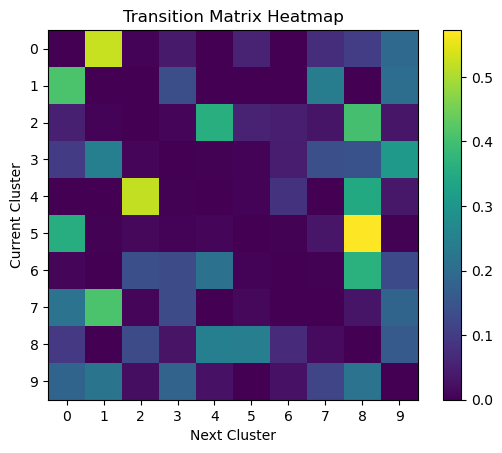

In [383]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_states = len(states)
# Example sequence of transitions
transitions = np.array(clustered_df['raw_kmeans_labels'])
transitions = transitions[np.append([True], np.diff(transitions) != 0)]
# Create a transition matrix
transition_matrix = np.zeros((len(states), len(states)))

# Populate the transition matrix
for i in range(len(transitions) - 1):
    current_state = transitions[i]
    next_state = transitions[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.title('Transition Matrix Heatmap')
plt.xticks(np.arange(num_states), np.arange(num_states))

# Set y-axis ticks and labels
plt.yticks(np.arange(num_states), np.arange(num_states))
# Show the plot
plt.show()

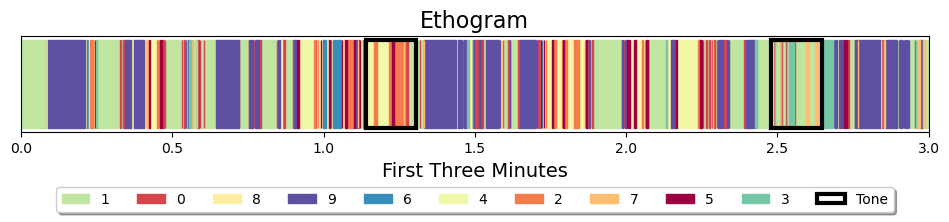

In [387]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(raw_recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = raw_recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("First Three Minutes", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 1.14, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.barh(1, .167, left = 2.48, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3)
#1.14277778,  2.47611111
ax.set_xlim((0,3))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()

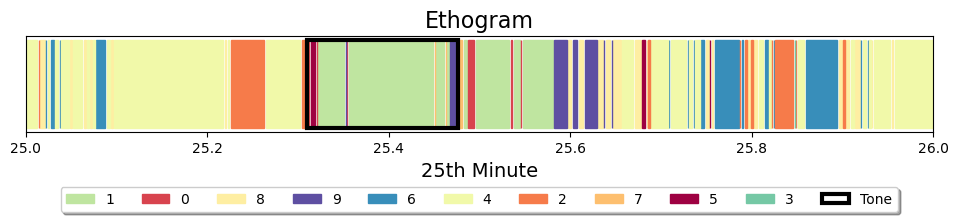

In [388]:
fig, ax = plt.subplots(figsize=(10, 3))
y_labels = list(raw_recording_cluster_dict.keys())
max_len = len(y_labels)
bars = {}
par1 = 1
bar_height = .75  # Adjust the bar height as needed

for i, cluster_label in enumerate(y_labels):
    start_stops = raw_recording_cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts, stops]

    # color
    bar_color = cluster_colors[cluster_label]
    ax.barh(
        1,
        stops - starts,
        left=starts,
        height=bar_height,
        align="center",
        edgecolor=bar_color,
        color=bar_color,
        alpha=1,
        label=cluster_label
    )

#ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels("")
ax.set_xlabel("25th Minute", fontsize = 14)
ax.set_title("Ethogram", fontsize = 16)
ax.invert_yaxis()
ax.barh(1, .167, left = 25.31, height=bar_height, align='center', edgecolor='black', color='none', linewidth=3, label = 'Tone')
ax.set_xlim((25,26))
ax.tick_params(left=False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncol=11)
plt.tight_layout()
plt.show()